<a href="https://colab.research.google.com/github/WeiMartin/CWIC/blob/master/fast_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!curl -s https://course.fast.ai/setup/colab | bash

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
! git clone https://github.com/NVIDIA/apex.git
% cd apex
! python setup.py install --cuda_ext --cpp_ext
! pip install .

In [0]:
path = '/content/drive/My Drive/UNET/simple_train_label/U-RISC_OPEN_DATA_SIMPLE'
path_lbl = os.path.join(path,'labels_01')
path_img = os.path.join(path,'img_gray')
path_test = os.path.join(path,'val_gray')

In [0]:
get_y_fn = lambda x:os.path.join(path_lbl,f'{x.stem}.tiff')

In [0]:
lnames = get_image_files(path_img)
mask = open_mask(get_y_fn(lnames[0]))
print(mask.data)
mask.show(figsize=(15,15), alpha=0.5)

In [0]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

In [0]:
size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=2
else:           bs=2
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=2, have 16270MB of GPU RAM free


In [0]:
src = (SegmentationItemList.from_folder(path)            #ItemList
    .split_by_folder(train='train_1', valid='val_1')       #ItemLists
    .label_from_func(get_y_fn,classes=['0','1'])         #
    .transform(get_transforms(), size=size, tfm_y=True)
    .add_test_folder('test_1',tfms=None, tfm_y=False)
    )

In [0]:
data = (src.databunch(bs=bs)
        .normalize((130.1,71.4)))

In [0]:
3*0.1+1

1.3

In [0]:
"""

Lovasz-Softmax and Jaccard hinge loss in PyTorch

Maxim Berman 2018 ESAT-PSI KU Leuven (MIT License)

"""



from __future__ import print_function, division



import torch

from torch.autograd import Variable

import torch.nn.functional as F

import numpy as np

try:

    from itertools import  ifilterfalse

except ImportError: # py3k

    from itertools import  filterfalse as ifilterfalse





def lovasz_grad(gt_sorted):

    """

    Computes gradient of the Lovasz extension w.r.t sorted errors

    See Alg. 1 in paper

    """

    p = len(gt_sorted)

    gts = gt_sorted.sum()

    intersection = gts - gt_sorted.float().cumsum(0)

    union = gts + (1 - gt_sorted).float().cumsum(0)

    jaccard = 1. - intersection / union

    if p > 1: # cover 1-pixel case

        jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]

    return jaccard





def iou_binary(preds, labels, EMPTY=1., ignore=None, per_image=True):

    """

    IoU for foreground class

    binary: 1 foreground, 0 background

    """

    if not per_image:

        preds, labels = (preds,), (labels,)

    ious = []

    for pred, label in zip(preds, labels):

        intersection = ((label == 1) & (pred == 1)).sum()

        union = ((label == 1) | ((pred == 1) & (label != ignore))).sum()

        if not union:

            iou = EMPTY

        else:

            iou = float(intersection) / float(union)

        ious.append(iou)

    iou = mean(ious)    # mean accross images if per_image

    return 100 * iou





def iou(preds, labels, C=2, EMPTY=1., ignore=None, per_image=False):

    """

    Array of IoU for each (non ignored) class

    """

    if not per_image:

        preds, labels = (preds,), (labels,)

    ious = []

    for pred, label in zip(preds, labels):

        iou = []    

        for i in range(C):

            if i != ignore: # The ignored label is sometimes among predicted classes (ENet - CityScapes)

                intersection = ((label == i) & (pred == i)).sum()

                union = ((label == i) | ((pred == i) & (label != ignore))).sum()

                if not union:

                    iou.append(EMPTY)

                else:

                    iou.append(float(intersection) / float(union))

        ious.append(iou)

    ious = [mean(iou) for iou in zip(*ious)] # mean accross images if per_image

    return 100 * np.array(ious)





# --------------------------- BINARY LOSSES ---------------------------





def lovasz_hinge(logits, labels, per_image=False, ignore=None):

    """

    Binary Lovasz hinge loss

      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)

      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)

      per_image: compute the loss per image instead of per batch

      ignore: void class id

    """
    #logits = torch.sigmoid(logits)
    if per_image:
        n = labels.shape[0]
        loss = 0.
        for i in range(n):
           
           loss = loss+lovasz_hinge_flat(*flatten_binary_scores(logits[i,:,:,:].unsqueeze(0), labels[i,:,:,:].unsqueeze(0), ignore))
        loss = loss/torch.tensor(n).float()
                          

    else:

        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))

    return loss





def lovasz_hinge_flat(logits, labels):

    """

    Binary Lovasz hinge loss

      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)

      labels: [P] Tensor, binary ground truth labels (0 or 1)

      ignore: label to ignore

    """

    if len(labels) == 0:

        # only void pixels, the gradients should be 0

        return logits.sum() * 0.
    
    
    #logits = 2.*(logits-0.5)
    #labels = 1.-labels

    #平衡
    s = labels.sum().float()
    sum = torch.ones_like(labels).sum().float()
    b = (s+600000.)/((sum-s)+600000.)

    signs = (1.+b) * labels.float() - b
    
    
    signs.requires_grad=True
    errors = ( 1.- logits *signs)
    
    
    
    errors_sorted, perm = torch.sort(errors, dim=0, descending=True)

    perm = perm.data

    gt_sorted = labels[perm]
    
    #平衡
    #s = torch.sign(signs.sum()).float()
    #errors_sorted = errors_sorted*(gt_sorted*(-10.)*s+11.)
    grad = lovasz_grad(gt_sorted)
    grad.requires_grad=True
    loss = torch.dot(F.elu(errors_sorted)+1,grad )

    return loss





def flatten_binary_scores(scores, labels, ignore=None):

    """

    Flattens predictions in the batch (binary case)

    Remove labels equal to 'ignore'

    """
    #print(scores.shape)
    #scores = F.softmax(scores,dim=1)[:,0,:,:]
    #print(scores.shape)
    #print(labels.shape)
    scores = scores.reshape(-1)  #view与reshape功能相同view只能操纵连续空间，这里【：，0，：，：】空间不连续

    labels = labels.view(-1)

    if ignore is None:

        return scores, labels

    valid = (labels != ignore)

    vscores = scores[valid]

    vlabels = labels[valid]

    return vscores, vlabels


class asymmetric_lovasz_loss(nn.Module):
    def __init__(self):
        super().__init__()
        

    def forward(self, input, label):
      #print(label.shape)
      #logits = F.softmax(input,dim =1)[:,1,:,:].unsqueeze(1)
      #print(label.shape)
      #print(logits.shape)
      return  (lovasz_hinge(input[:,1,:,:]-input[:,0,:,:], label) + lovasz_hinge(input[:,0,:,:]-input[:,1,:,:], 1. - label)) / 2.
      #return lovasz_hinge(input[:,0,:,:]-input[:,1,:,:], 1. - label)
#def symmetric_lovasz(outputs, targets): return (lovasz_hinge(input[:,1,:,:], targets) + lovasz_hinge(input[:,0,:,:], 1 - targets)) / 2

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class SoftDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(SoftDiceLoss, self).__init__()
 
    def forward(self, logits, targets):
        targets = 1-targets
        num = targets.size(0)
        smooth = 1       
        probs = F.softmax(logits,dim=1)
        
        
        m1 = probs[:,0,:,:].view(num, -1)
        m2 = targets.view(num, -1)
        intersection = (m1 * m2)
        weight = (intersection<0.5).float()*2.+1
        intersection = intersection*weight
        score = 2. * (intersection.sum(1) + smooth).float() / (m1.sum(1) + m2.sum(1) + smooth).float()
        score = 1 - score.sum() / num
        return score
        #return score +F.binary_cross_entropy_with_logits(logits[:,0,:,:].view(num, -1),targets.view(num, -1).float())

In [0]:
def s_0(input, target):
    target = target.squeeze(1)
    s = target.sum().float()
    t = torch.ones_like(target).sum().float()
    target = target*3

    s_0 = (input.argmax(dim=1)==target).sum().float()/(t-s)
    
    return s_0
def s_1(input, target):
    target = target.squeeze(1)
    s = target.sum().float()
    t = torch.ones_like(target).sum().float()
    target = target*3

    #s_0 = (input.argmax(dim=1)==target).sum().float()/(t-s)
    target = target-2
    s_1 = (input.argmax(dim=1)==target).sum().float()/s
    #print('s_0={},   s_1={}'.format(s_0,s_1))
    return s_1
def acc_camvid(input, target):
    target = target.squeeze(1)
    s = target.sum().float()
    t = torch.ones_like(target).sum().float()
    target = target*3

    s_0 = (input.argmax(dim=1)==target).sum().float()/(t-s)
    target = target-2
    s_1 = (input.argmax(dim=1)==target).sum().float()/s
    #print('s_0={},   s_1={}'.format(s_0,s_1))
    return s_0+s_1

In [0]:
a=torch.ones(1,2)
b=(a>1).float()
b

tensor([[0., 0.]])

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, pos_weight,gamma=2,top_k=1):
        super().__init__()
        self.gamma = gamma
        self.top_k=top_k
        
        self.pos_weight=pos_weight

    def forward(self, input, label):
        size = list(label.size())
        label = label.view(-1)   # reshape 为向量
        ones = torch.sparse.torch.eye(2).cuda()
        ones = ones.index_select(0, label)   # 用上面的办法转为换one hot
        size.append(2)  # 把类别输目添到size的尾后，准备reshape回原来的尺寸
        target = ones.view(*size).permute(0,4,1,2,3).squeeze(2)

        
        
        #print(input[:,0,:,:])
        #print(input[:,1,:,:])
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))
        if self.pos_weight.shape != torch.Size([]):

            pos_weight = self.pos_weight-1
            #log_weight = (pos_weight - 1)*(target)+1
            log_weight = target
            log_weight[:,0,:,:] = log_weight[:,0,:,:]*pos_weight[0]
            log_weight[:,1,:,:] = log_weight[:,1,:,:]*pos_weight[1]
            log_weight = log_weight+1
            max_val = (-input).clamp(min=0)
            loss = input - input * target + log_weight*(max_val + ((-max_val).exp() + (-input - max_val).exp()).log())
        else:
            max_val = (-input).clamp(min=0)
            loss = input - input * target + max_val + ((-max_val).exp() + (-input - max_val).exp()).log()
        #loss = (1 - target).mul_(input).add_(log_weight.mul_(((-max_val).exp_().add_((-input - max_val).exp_())).log_().add_(max_val)));
        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        focal_loss = torch.ones_like(loss)
        #print(loss.shape)
        focal_loss[:,1,:,:] = (invprobs[:,1,:,:] * self.gamma).exp() * loss[:,1,:,:]     #只对背景gamma
        focal_loss[:,0,:,:] = loss[:,0,:,:]
        topk_loss, idxs = torch.topk(focal_loss, int(self.top_k * loss.size()[2]),dim=2)

        
        return topk_loss.sum(dim=1).mean()

In [0]:
class MSELOSS(nn.Module):
    def __init__(self):
        super().__init__() 
        

    def forward(self, input, label):
      logits = F.softmax(input,dim =1)[:,1,:,:].float()
      label = label.squeeze(1).float()
      #print(label)
      a = (F.mse_loss(logits,label,reduction='none')>0.25).float()
      #print(a)
      loss=F.mse_loss(logits,label.squeeze(1),reduction='none')*(label*(-4.)+5.)*a
      #print((label*(-2.)+3.)*a)
      #print(loss)
      return loss.mean()


In [0]:
def Dice(input:Tensor, targs:Tensor, iou:bool=False, eps:float=1e-8):
    "Dice coefficient metric for binary target. If iou=True, returns iou metric, classic for segmentation problems."
    n = targs.shape[0]
    targs = 1-targs
    input = input.argmax(dim=1).view(n,-1)
    input = 1-input
    targs = targs.view(n,-1)
    intersect = (input * targs).sum(dim=1).float()
    union = (input+targs).sum(dim=1).float()
    if not iou: l = 2. * intersect / union
    else: l = intersect / (union-intersect+eps)
    l[union == 0.] = 1.
    return l.mean()
def iou(input:Tensor, targs:Tensor, iou:bool=True, eps:float=1e-8):
    "Dice coefficient metric for binary target. If iou=True, returns iou metric, classic for segmentation problems."
    n = targs.shape[0]
    targs = 1-targs
    input = input.argmax(dim=1).view(n,-1)
    input = 1-input
    targs = targs.view(n,-1)
    intersect = (input * targs).sum(dim=1).float()
    union = (input+targs).sum(dim=1).float()
    if not iou: l = 2. * intersect / union
    else: l = intersect / (union-intersect+eps)
    l[union == 0.] = 1.
    return l.mean()


In [0]:

wd=1e-2
learn = unet_learner(data, models.resnet34, metrics=[s_0,s_1,acc_camvid,Dice,iou], wd=wd).to_fp16()
#learn.loss_func = BCEWithLogitsFlat(pos_weight=torch.tensor([10,1]).float().cuda())

In [0]:
learn.unfreeze()
learn.load('/content/drive/My Drive/UNET/asymLovasz');
learn.unfreeze()

In [0]:
learn.metrics=[s_0,s_1,acc_camvid,Dice,iou]

In [0]:
learn.loss_func = asymmetric_lovasz_loss()

In [0]:
torch.autograd.set_detect_anomaly(True)

In [0]:
lr_find(learn,start_lr=1e-12)
learn.recorder.plot()

epoch,train_loss,valid_loss,s_0,s_1,acc_camvid,Dice,iou,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


KeyboardInterrupt: ignored

In [0]:
lr=3e-5

In [0]:
learn.fit_one_cycle(5000, slice(1e-6,lr/5),callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='Dice',mode='max', name='/content/drive/My Drive/UNET/asymLovasz_unfreeze')])
#learn.save('/content/drive/My Drive/UNET/fast_unet_1_1')e_cycle(5000, slice(lr),callbacks=[callbacks.SaveMme='/content/drive/My Drive/UNET/Focal+DiceANDBCE_1odelCallback(learn, every='improvement', monitor='Dice',mode='max', na')])
#learn.save('/content/drive/My Drive/UNET/fast_unet_1_1')

epoch,train_loss,valid_loss,s_0,s_1,acc_camvid,Dice,iou,time
0,1.761934,1.723458,0.445762,0.895140,1.340901,0.323426,0.193189,02:16
1,1.757343,1.736204,0.416561,0.906497,1.323058,0.321965,0.192185,02:16
2,1.743697,1.717420,0.436023,0.899939,1.335962,0.324795,0.194149,02:16


Better model found at epoch 0 with Dice value: 0.32342636585235596.
Better model found at epoch 2 with Dice value: 0.3247950077056885.


KeyboardInterrupt: ignored

In [0]:
#learn.unfreeze()
learn.load('/content/drive/My Drive/UNET/LV_best_5');
learn.unfreeze()

In [0]:
"""

Lovasz-Softmax and Jaccard hinge loss in PyTorch

Maxim Berman 2018 ESAT-PSI KU Leuven (MIT License)

"""



from __future__ import print_function, division



import torch

from torch.autograd import Variable

import torch.nn.functional as F

import numpy as np

try:

    from itertools import  ifilterfalse

except ImportError: # py3k

    from itertools import  filterfalse as ifilterfalse





def lovasz_grad(gt_sorted):

    """

    Computes gradient of the Lovasz extension w.r.t sorted errors

    See Alg. 1 in paper

    """

    p = len(gt_sorted)

    gts = gt_sorted.sum()

    intersection = gts - gt_sorted.float().cumsum(0)

    union = gts + (1 - gt_sorted).float().cumsum(0)

    jaccard = 1. - intersection / union

    if p > 1: # cover 1-pixel case

        jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]

    return jaccard





def iou_binary(preds, labels, EMPTY=1., ignore=None, per_image=True):

    """

    IoU for foreground class

    binary: 1 foreground, 0 background

    """

    if not per_image:

        preds, labels = (preds,), (labels,)

    ious = []

    for pred, label in zip(preds, labels):

        intersection = ((label == 1) & (pred == 1)).sum()

        union = ((label == 1) | ((pred == 1) & (label != ignore))).sum()

        if not union:

            iou = EMPTY

        else:

            iou = float(intersection) / float(union)

        ious.append(iou)

    iou = mean(ious)    # mean accross images if per_image

    return 100 * iou





def iou(preds, labels, C=2, EMPTY=1., ignore=None, per_image=False):

    """

    Array of IoU for each (non ignored) class

    """

    if not per_image:

        preds, labels = (preds,), (labels,)

    ious = []

    for pred, label in zip(preds, labels):

        iou = []    

        for i in range(C):

            if i != ignore: # The ignored label is sometimes among predicted classes (ENet - CityScapes)

                intersection = ((label == i) & (pred == i)).sum()

                union = ((label == i) | ((pred == i) & (label != ignore))).sum()

                if not union:

                    iou.append(EMPTY)

                else:

                    iou.append(float(intersection) / float(union))

        ious.append(iou)

    ious = [mean(iou) for iou in zip(*ious)] # mean accross images if per_image

    return 100 * np.array(ious)





# --------------------------- BINARY LOSSES ---------------------------





def lovasz_hinge(logits, labels, per_image=False, ignore=None):

    """

    Binary Lovasz hinge loss

      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)

      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)

      per_image: compute the loss per image instead of per batch

      ignore: void class id

    """
    #logits = torch.sigmoid(logits)
    if per_image:
        n = labels.shape[0]
        loss = 0.
        for i in range(n):
           
           loss = loss+lovasz_hinge_flat(*flatten_binary_scores(logits[i,:,:,:].unsqueeze(0), labels[i,:,:,:].unsqueeze(0), ignore))
        loss = loss/torch.tensor(n).float()
                          

    else:

        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))

    return loss





def lovasz_hinge_flat(logits, labels):

    """

    Binary Lovasz hinge loss

      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)

      labels: [P] Tensor, binary ground truth labels (0 or 1)

      ignore: label to ignore

    """

    if len(labels) == 0:

        # only void pixels, the gradients should be 0

        return logits.sum() * 0.
    
    
    #logits = 2.*(logits-0.5)
    #labels = 1.-labels

    #平衡
    s = labels.sum().float()
    sum = torch.ones_like(labels).sum().float()
    b = (s+600000.)/((sum-s)+600000.)

    signs = (1.+b) * labels.float() - b
    
    
    signs.requires_grad=True
    errors = ( 1.- logits *signs)

    errors_sorted, perm = torch.sort(errors, dim=0, descending=True)

    perm = perm.data

    gt_sorted = labels[perm]
    
    #平衡
    #s = torch.sign(signs.sum()).float()
    #errors_sorted = errors_sorted*(gt_sorted*(-10.)*s+11.)
    grad = lovasz_grad(gt_sorted)
    grad.requires_grad=True
    loss = torch.dot(F.elu(errors_sorted)+1,grad )

    return loss





def flatten_binary_scores(scores, labels, ignore=None):

    """

    Flattens predictions in the batch (binary case)

    Remove labels equal to 'ignore'

    """
    #print(scores.shape)
    #scores = F.softmax(scores,dim=1)[:,0,:,:]
    #print(scores.shape)
    #print(labels.shape)
    scores = scores.reshape(-1)  #view与reshape功能相同view只能操纵连续空间，这里【：，0，：，：】空间不连续

    labels = labels.view(-1)

    if ignore is None:

        return scores, labels

    valid = (labels != ignore)

    vscores = scores[valid]

    vlabels = labels[valid]

    return vscores, vlabels


class symmetric_lovasz_loss(nn.Module):
    def __init__(self):
        super().__init__()
        

    def forward(self, input, label):
      #print(label.shape)
      logits = F.softmax(input,dim =1)[:,1,:,:].unsqueeze(1)
      #print(label.shape)
      #print(logits.shape)
      #return  (lovasz_hinge(input[:,1,:,:], label) + lovasz_hinge(input[:,0,:,:], 1. - label)) / 2.
      return lovasz_hinge(input[:,0,:,:], 1. - label)
#def symmetric_lovasz(outputs, targets): return (lovasz_hinge(input[:,1,:,:], targets) + lovasz_hinge(input[:,0,:,:], 1 - targets)) / 2

In [0]:
learn.load('/content/drive/My Drive/UNET/LV_best_6');
#learn.unfreeze()
#learn.load('/content/drive/My Drive/UNET/fast_unet_best_5');

In [0]:
"""

Lovasz-Softmax and Jaccard hinge loss in PyTorch

Maxim Berman 2018 ESAT-PSI KU Leuven (MIT License)

"""



from __future__ import print_function, division



import torch

from torch.autograd import Variable

import torch.nn.functional as F

import numpy as np

try:

    from itertools import  ifilterfalse

except ImportError: # py3k

    from itertools import  filterfalse





def lovasz_grad(gt_sorted):

    """

    Computes gradient of the Lovasz extension w.r.t sorted errors

    See Alg. 1 in paper

    """

    p = len(gt_sorted)

    gts = gt_sorted.sum()

    intersection = gts - gt_sorted.float().cumsum(0)

    union = gts + (1 - gt_sorted).float().cumsum(0)

    jaccard = 1. - intersection / union

    if p > 1: # cover 1-pixel case

        jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]

    return jaccard





def iou_binary(preds, labels, EMPTY=1., ignore=None, per_image=True):

    """

    IoU for foreground class

    binary: 1 foreground, 0 background

    """

    if not per_image:

        preds, labels = (preds,), (labels,)

    ious = []

    for pred, label in zip(preds, labels):

        intersection = ((label == 1) & (pred == 1)).sum()

        union = ((label == 1) | ((pred == 1) & (label != ignore))).sum()

        if not union:

            iou = EMPTY

        else:

            iou = float(intersection) / union

        ious.append(iou)

    iou = mean(ious)    # mean accross images if per_image

    return 100 * iou





def iou(preds, labels, C, EMPTY=1., ignore=None, per_image=False):

    """

    Array of IoU for each (non ignored) class

    """

    if not per_image:

        preds, labels = (preds,), (labels,)

    ious = []

    for pred, label in zip(preds, labels):

        iou = []    

        for i in range(C):

            if i != ignore: # The ignored label is sometimes among predicted classes (ENet - CityScapes)

                intersection = ((label == i) & (pred == i)).sum()

                union = ((label == i) | ((pred == i) & (label != ignore))).sum()

                if not union:

                    iou.append(EMPTY)

                else:

                    iou.append(float(intersection) / union)

        ious.append(iou)

    ious = map(mean, zip(*ious)) # mean accross images if per_image

    return 100 * np.array(ious)





def lovasz_softmax(probas, labels, only_present=False, per_image=False, ignore=None):

    """

    Multi-class Lovasz-Softmax loss

      probas: [B, C, H, W] Variable, class probabilities at each prediction (between 0 and 1)

      labels: [B, H, W] Tensor, ground truth labels (between 0 and C - 1)

      only_present: average only on classes present in ground truth

      per_image: compute the loss per image instead of per batch

      ignore: void class labels

    """

    if per_image:

        loss = mean(lovasz_softmax_flat(*flatten_probas(prob.unsqueeze(0), lab.unsqueeze(0), ignore), only_present=only_present)

                          for prob, lab in zip(probas, labels))

    else:

        loss = lovasz_softmax_flat(*flatten_probas(probas, labels, ignore), only_present=only_present)

    return loss





def lovasz_softmax_flat(probas, labels, only_present=False):

    """

    Multi-class Lovasz-Softmax loss

      probas: [P, C] Variable, class probabilities at each prediction (between 0 and 1)

      labels: [P] Tensor, ground truth labels (between 0 and C - 1)

      only_present: average only on classes present in ground truth

    """

    C = probas.size(1)

    losses = []

    for c in range(C):

        fg = (labels == c).float() # foreground for class c

        if only_present and fg.sum() == 0:

            continue

        errors = (Variable(fg) - probas[:, c]).abs()

        errors_sorted, perm = torch.sort(errors, 0, descending=True)

        perm = perm.data

        fg_sorted = fg[perm]

        losses.append(torch.dot(errors_sorted, Variable(lovasz_grad(fg_sorted))))
    

    return losses[0]+losses[1]





def flatten_probas(probas, labels, ignore=None):

    """

    Flattens predictions in the batch

    """

    B, C, H, W = probas.size()

    probas = probas.permute(0, 2, 3, 1).contiguous().view(-1, C)  # B * H * W, C = P, C

    labels = labels.view(-1)

    if ignore is None:

        return probas, labels

    valid = (labels != ignore)

    vprobas = probas[valid.nonzero().squeeze()]

    vlabels = labels[valid]

    return vprobas, vlabels



def xloss(logits, labels, ignore=None):

    """

    Cross entropy loss

    """

    return F.cross_entropy(logits, Variable(labels), ignore_index=255)





# --------------------------- HELPER FUNCTIONS ---------------------------



def mean(l, ignore_nan=False, empty=0):

    """

    nanmean compatible with generators.

    """

    l = iter(l)

    if ignore_nan:

        l = ifilterfalse(np.isnan, l)

    try:

        n = 1

        acc = next(l)

    except StopIteration:

        if empty == 'raise':

            raise ValueError('Empty mean')

        return empty

    for n, v in enumerate(l, 2):

        acc += v

    if n == 1:

        return acc

    return acc / n


class lovasz_softmax_loss(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, input, label):
      probas = F.softmax(input,dim=1)
      
      return  lovasz_softmax(probas, label, only_present=False, per_image=False, ignore=None)

class combined_loss(nn.Module):
  def __init__(self):
        super().__init__()
  def forward(self, input, label):
    probas = torch.sigmoid(input,dim=1)

    
    
    lh_loss = lovasz_softmax(probas, label, only_present=False, per_image=False, ignore=None)
    label = label.squeeze(1).float()
    bce_loss = F.binary_cross_entropy_with_logits(probas[:,1,:,:], label)
    
    return 0.8 * bce_loss + lh_loss


In [0]:
lr_find(learn,start_lr=1e-12)
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5000, slice(1e-10,1e-9),callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='Dice',mode='max', name='/content/drive/My Drive/UNET/LV_best_7')])
#learn.save('/content/drive/My Drive/UNET/fast_unet_1_1')

In [0]:

a = learn.TTA(ds_type=DatasetType.Test)
print(a[1].shape)

In [0]:
"""

Lovasz-Softmax and Jaccard hinge loss in PyTorch

Maxim Berman 2018 ESAT-PSI KU Leuven (MIT License)

"""



from __future__ import print_function, division



import torch

from torch.autograd import Variable

import torch.nn.functional as F

import numpy as np

try:

    from itertools import  ifilterfalse

except ImportError: # py3k

    from itertools import  filterfalse as ifilterfalse





def lovasz_grad(gt_sorted):

    """

    Computes gradient of the Lovasz extension w.r.t sorted errors

    See Alg. 1 in paper

    """

    p = len(gt_sorted)

    gts = gt_sorted.sum()

    intersection = gts - gt_sorted.float().cumsum(0)

    union = gts + (1 - gt_sorted).float().cumsum(0)

    jaccard = intersection / union

    if p > 1: # cover 1-pixel case

        jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]

    return jaccard





def iou_binary(preds, labels, EMPTY=1., ignore=None, per_image=True):

    """

    IoU for foreground class

    binary: 1 foreground, 0 background

    """

    if not per_image:

        preds, labels = (preds,), (labels,)

    ious = []

    for pred, label in zip(preds, labels):

        intersection = ((label == 1) & (pred == 1)).sum()

        union = ((label == 1) | ((pred == 1) & (label != ignore))).sum()

        if not union:

            iou = EMPTY

        else:

            iou = float(intersection) / float(union)

        ious.append(iou)

    iou = mean(ious)    # mean accross images if per_image

    return 100 * iou





def iou(preds, labels, C, EMPTY=1., ignore=None, per_image=False):

    """

    Array of IoU for each (non ignored) class

    """

    if not per_image:

        preds, labels = (preds,), (labels,)

    ious = []

    for pred, label in zip(preds, labels):

        iou = []    

        for i in range(C):

            if i != ignore: # The ignored label is sometimes among predicted classes (ENet - CityScapes)

                intersection = ((label == i) & (pred == i)).sum()

                union = ((label == i) | ((pred == i) & (label != ignore))).sum()

                if not union:

                    iou.append(EMPTY)

                else:

                    iou.append(float(intersection) / float(union))

        ious.append(iou)

    ious = [mean(iou) for iou in zip(*ious)] # mean accross images if per_image

    return 100 * np.array(ious)





# --------------------------- BINARY LOSSES ---------------------------





def conti_Dice(logits, labels, per_image=False, ignore=None):

    """

    Binary Lovasz hinge loss

      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)

      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)

      per_image: compute the loss per image instead of per batch

      ignore: void class id

    """
    #logits = torch.sigmoid(logits)
    if per_image:
        n = labels.shape[0]
        loss = 0.
        for i in range(n):
           
           loss = loss+lovasz_hinge_flat(*flatten_binary_scores(logits[i,:,:,:].unsqueeze(0), labels[i,:,:,:].unsqueeze(0), ignore))
        loss = loss/torch.tensor(n).float()
                          

    else:

        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))

    return loss





def lovasz_hinge_flat(logits, labels):

    """

    Binary Lovasz hinge loss

      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)

      labels: [P] Tensor, binary ground truth labels (0 or 1)

      ignore: label to ignore

    """

    if len(labels) == 0:

        # only void pixels, the gradients should be 0

        return logits.sum() * 0.
    
    
    #logits = 2.*(logits-0.5)
    #labels = 1.-labels
    intersection = (logits*labels)
    #intersection.requires_grad
    #signs = 2. * labels.float() - 1.
    #signs.requires_grad=True
    #errors = ( - logits *signs)

    intersec_sorted, perm = torch.sort(intersection, dim=0, descending=True)

    perm = perm.data
    #print(labels.shape)
    #print(perm.shape)
    gt_sorted = labels[perm]
    
    #平衡
    #s = torch.sign(signs.sum()).float()
    #errors_sorted = errors_sorted*(gt_sorted*(-10.)*s+11.)
    grad = lovasz_grad(gt_sorted)
    grad.requires_grad=True
    conti_intersection = torch.dot(intersec_sorted,grad )

    return 1-conti_intersection





def flatten_binary_scores(scores, labels, ignore=None):

    """

    Flattens predictions in the batch (binary case)

    Remove labels equal to 'ignore'

    """
    #print(scores.shape)
    #scores = F.softmax(scores,dim=1)[:,0,:,:]
    #print(scores.shape)
    #print(labels.shape)
    scores = scores.reshape(-1)  #view与reshape功能相同view只能操纵连续空间，这里【：，0，：，：】空间不连续

    labels = labels.view(-1)
    #labels = 1.-labels
    if ignore is None:

        return scores, labels

    valid = (labels != ignore)

    vscores = scores[valid]

    vlabels = labels[valid]

    return vscores, vlabels

class conti_dice_loss(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, input, label):
      input = F.softmax(input,dim=1)
      
      return  conti_Dice(input[:,1,:,:],label)

class conti_dice_loss_b(nn.Module):
    def __init__(self):
        super().__init__()
        

    def forward(self, input, label):
      input = F.softmax(input,dim=1)
      loss_0 = conti_Dice(input[:,0,:,:], 1.-label)
      loss_1 = conti_Dice(input[:,1,:,:],label)
      #D = loss_0/loss_1
      return  loss_0+2*loss_1

#def symmetric_lovasz(outputs, targets): return (lovasz_hinge(input[:,1,:,:], targets) + lovasz_hinge(input[:,0,:,:], 1 - targets)) / 2

In [0]:
learn.loss_func = SoftDiceLoss()

In [0]:
learn.unfreeze()
learn.load('/content/drive/My Drive/UNET/LV_best_4');


In [0]:
learn.loss_func = FocalLoss(torch.tensor())

In [0]:
learn.load('/content/drive/My Drive/UNET/LV_best_4');

In [0]:
data.show_batch(2, figsize=(10,7))

In [0]:
learn.unfreeze()

In [0]:
learn.loss_func = FocalLoss(pos_weight=torch.tensor([1.5,2/3]).float(),top_k=1)

In [0]:
learn.wd = 1e-1
lr_find(learn,start_lr=1e-12)
learn.recorder.plot()

In [0]:
fbeta??

In [0]:
learn.fit_one_cycle(500, slice(1e-6,1e-5),callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='f1',mode='max', name='/content/drive/My Drive/UNET/fast_unet_best_6')])
#learn.save('/content/drive/My Drive/UNET/fast_unet_1_3')
#learn.export('/content/drive/My Drive/UNET/fast_net_1_2.pkl')

In [0]:
a=torch.ones(2,1,3,4)
b=a.sum(dim=1)
b.shape

In [0]:
learn.save('/content/drive/My Drive/UNET/fast_unet_best_4')

In [0]:
learn.loss_func.weight=torch.tensor([10,1]).float().cuda()

In [0]:
x,t = next(iter(data.train_dl))
learn.model(x).shape, t.shape

In [0]:
learn.model

In [0]:
learn.model

In [0]:
learn.show_results(rows=3, figsize=(8,9))

In [0]:
learn.load('/content/drive/My Drive/UNET/fast_unet_best_1');

In [0]:
learn.data.bs=2

In [0]:
learn.unfreeze()

In [0]:
learn.loss_func.weight=torch.tensor([10,1]).float().cuda()

In [0]:
learn.loss_func.weight=torch.tensor([3,1]).float().cuda()

In [0]:


class _Loss(Module):
    def __init__(self, size_average=None, reduce=None, reduction='mean'):
        super(_Loss, self).__init__()
        if size_average is not None or reduce is not None:
            self.reduction = _Reduction.legacy_get_string(size_average, reduce)
        else:
            self.reduction = reduction


class _WeightedLoss(_Loss):
    def __init__(self, weight=None, size_average=None, reduce=None, reduction='mean'):
        super(_WeightedLoss, self).__init__(size_average, reduce, reduction)
        self.register_buffer('weight', weight)
class topk_crossEntrophy(_WeightedLoss):

    def __init__(self, top_k=1, weight=None, size_average=None,
                    ignore_index=-100, reduce=None, reduction='none'):
        super(topk_crossEntrophy, self).__init__(weight, size_average, reduce, reduction)
    
        self.ignore_index = ignore_index
        self.top_k = top_k
        self.loss = nn.NLLLoss(weight=self.weight, 
                ignore_index=self.ignore_index, reduction='none')

    def forward(self, input, target):
        loss = self.loss(F.log_softmax(input, dim=1), target.squeeze(1))
        #print(loss)
    
        if self.top_k == 1:
            return torch.mean(loss)
        else:
            valid_loss, idxs = torch.topk(loss, int(self.top_k * loss.size()[1]),dim=1)
            
            #print(valid_loss.size())    
            return torch.mean(valid_loss)

In [0]:
learn.wd = 1e-1
lr_find(learn,start_lr=1e-12)
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(500, slice(1e-10,9e-10),callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='acc_camvid',mode='max', name='/content/drive/My Drive/UNET/fast_unet_best_4')])


In [0]:
learn.loss_func=topk_crossEntrophy(weight=torch.tensor([3,1]).float().cuda(),top_k=0.7)

In [0]:
learn.load('/content/drive/My Drive/UNET/fast_unet_best_4');

In [0]:
learn.wd = 1e-1
lr_find(learn,start_lr=1e-12)
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(500, slice(1e-5),callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='acc_camvid',mode='max', name='/content/drive/My Drive/UNET/fast_unet_best_2')])


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        ##input.shape
        #target.shape
        input = input[:,1,:,:].view(target.shape)
        #print(input[:,0,:,:])
        #print(input[:,1,:,:])
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        focal_loss = (invprobs * self.gamma).exp() * loss 


        
        return focal_loss.sum(dim=1).mean()

In [0]:
learn.loss_func = FocalLoss()

In [0]:
#learn.loss_func.weight=torch.tensor([9,1]).float().cuda()
learn.wd = 1e-1
lr_find(learn,start_lr=1e-12)
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(500, slice(1e-4,5e-4),callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='acc_camvid',mode='max', name='/content/drive/My Drive/UNET/fast_unet_best_5')])


In [0]:
learn.load('/content/drive/My Drive/UNET/fast_unet_best_3');

In [0]:
learn.show_results(rows=3, figsize=(10,10))

In [0]:
learn.export('/content/drive/My Drive/UNET/fast_net.pkl')

In [0]:
learn = load_learner('/content/drive/My Drive/UNET','fast_net.pkl')

In [0]:
src = (SegmentationItemList.from_folder(path_img)
    .split_by_rand_pct(valid_pct=0.1,seed=1)
    .label_from_func(get_y_fn,classes=['0','1'])
    .add_test_folder('/content/drive/My Drive/UNET/simple_train_label/U-RISC_OPEN_DATA_SIMPLE/test'))
data = (src.transform(get_transforms(), size=size, tfm_y=None)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [0]:
learn.predict??

In [0]:
data.test_dl.add_tfm(to_half)
print(data.test_dl)

In [0]:
from os.path import join,splitext
from os import listdir
from PIL import Image as Img
from torchvision import transforms
import numpy as np
#learn.model.float()
#learn.to_fp16()
tnames = [splitext(x)[0]for x in listdir('/content/drive/My Drive/UNET/simple_train_label/U-RISC_OPEN_DATA_SIMPLE/test')]
for i in range(len(tnames)):
  print(tnames[i])
  img = data.test_ds[i][0]
  print(data.train_dl)
  #print(img)
  
  y = learn.predict(img)
  #y=data.analyze_pred()
  #print(y)
  
  y[0].save('/content/drive/My Drive/UNET/simple_train_label/U-RISC_OPEN_DATA_SIMPLE/test_labels/0.tiff')
  y = Img.open('/content/drive/My Drive/UNET/simple_train_label/U-RISC_OPEN_DATA_SIMPLE/test_labels/0.tiff')
  #y = y.crop([4,2,1020,1021])   #左上角为（0，0）
  y = np.array(y)
  #y = np.pad(y, ((4, 3),(2,2)), 'reflect')
  #print(y.shape)

  y=y*255
  y=Img.fromarray(np.uint8(y)).convert('L')
  y.save(join('/content/drive/My Drive/UNET/simple_train_label/U-RISC_OPEN_DATA_SIMPLE/test_labels',tnames[i]+'.tiff'),quality=95)


0041_1
DeviceDataLoader(dl=<torch.utils.data.dataloader.DataLoader object at 0x7fee3cdee3c8>, device=device(type='cuda'), tfms=[functools.partial(<function _normalize_batch at 0x7fee3ce306a8>, mean=tensor(130.1000), std=tensor(71.4000), do_x=True, do_y=False), <function batch_to_half at 0x7fee458b91e0>], collate_fn=<function data_collate at 0x7fee458b4510>)
0046_1
DeviceDataLoader(dl=<torch.utils.data.dataloader.DataLoader object at 0x7fee3cdee3c8>, device=device(type='cuda'), tfms=[functools.partial(<function _normalize_batch at 0x7fee3ce306a8>, mean=tensor(130.1000), std=tensor(71.4000), do_x=True, do_y=False), <function batch_to_half at 0x7fee458b91e0>], collate_fn=<function data_collate at 0x7fee458b4510>)
0047_1
DeviceDataLoader(dl=<torch.utils.data.dataloader.DataLoader object at 0x7fee3cdee3c8>, device=device(type='cuda'), tfms=[functools.partial(<function _normalize_batch at 0x7fee3ce306a8>, mean=tensor(130.1000), std=tensor(71.4000), do_x=True, do_y=False), <function batch_to_

In [0]:
img = data.train_ds[0][0]
print(data.train_dl)
y = learn.predict(img)
#y=data.analyze_pred()
y[0].show(figsize=(15,15))

In [0]:
learn.get_preds(ds_type=DatasetType.Train)

In [0]:
data.analyze_pred??

In [0]:
test_path='/content/drive/My Drive/UNET/simple_train_label/U-RISC_OPEN_DATA_SIMPLE/test'
test_imgs = (test_path).ls()
#test_imgs.sort(key=lambda x: x.stem)
data.add_test(test_imgs) 
learn.data = data
preds = learn.get_preds(ds_type=DatasetType.Test)

In [0]:
doc(learn.fit_one_cycle)

In [0]:
accuracy

In [0]:

# 图片二值化
import numpy as np
from PIL import Image as Img
#from os.path import listdir 
names = get_image_files('/content/drive/My Drive/UNET/simple_train_label/U-RISC_OPEN_DATA_SIMPLE/labels_1')
#print(names)



for k in range(len(names)):
  img = np.array(Img.open(names[k]).convert('L'))
  

  rows,cols=img.shape                #获取像素坐标（rows,cols）
  for i in range(rows):
    for j in range(cols):
        if (img[i,j]<=122):               #判断该点的值
            img[i,j]=0
        else:
            img[i,j]=1
  img = Img.fromarray(img.astype('uint8')).convert('L')
  img.save(names[k])
  





0001_1


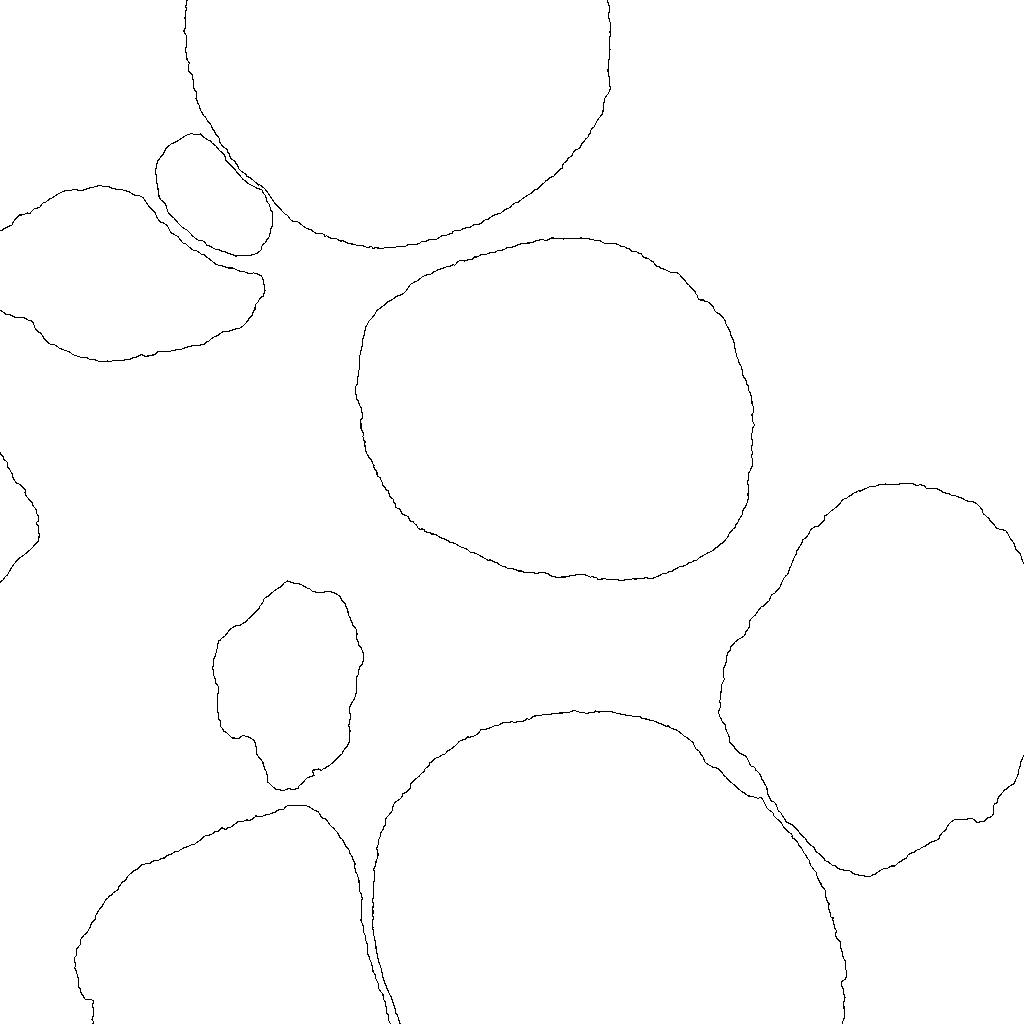

0009_1


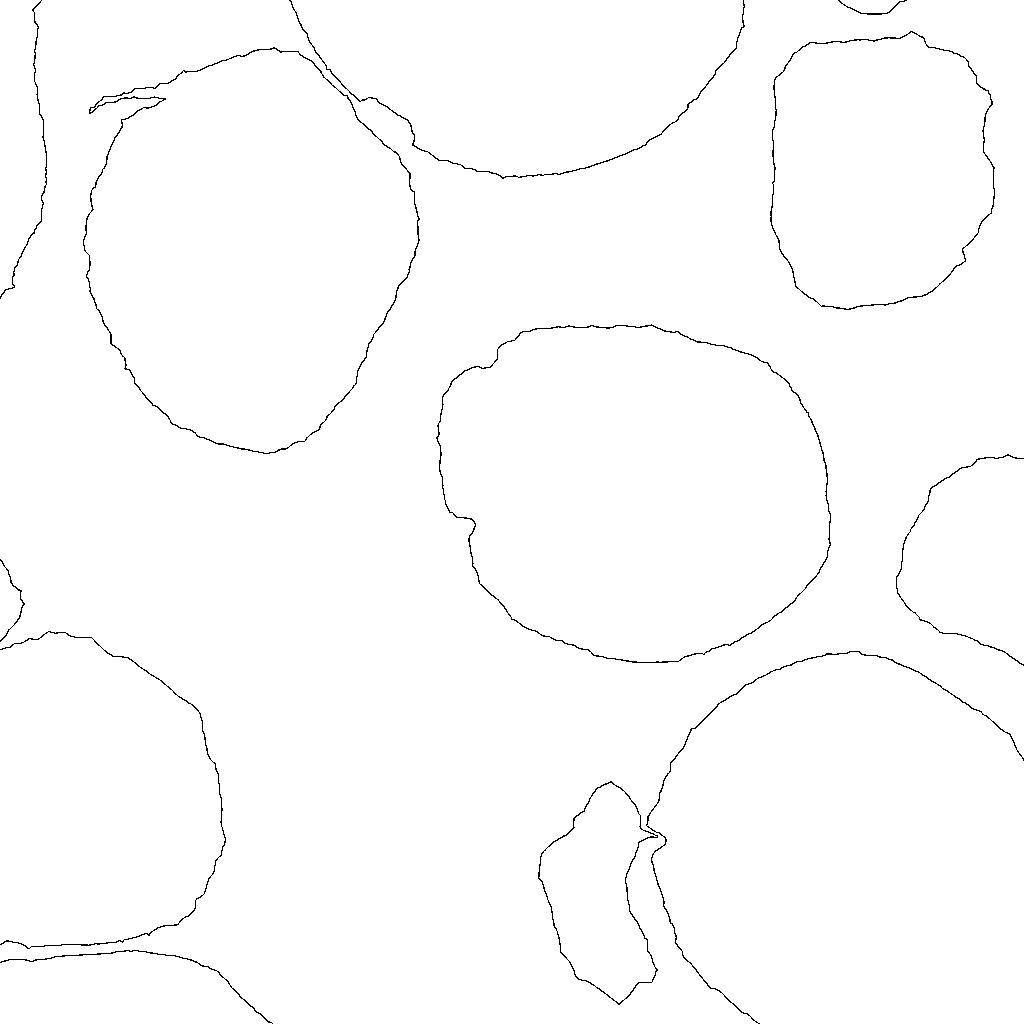

0020_1


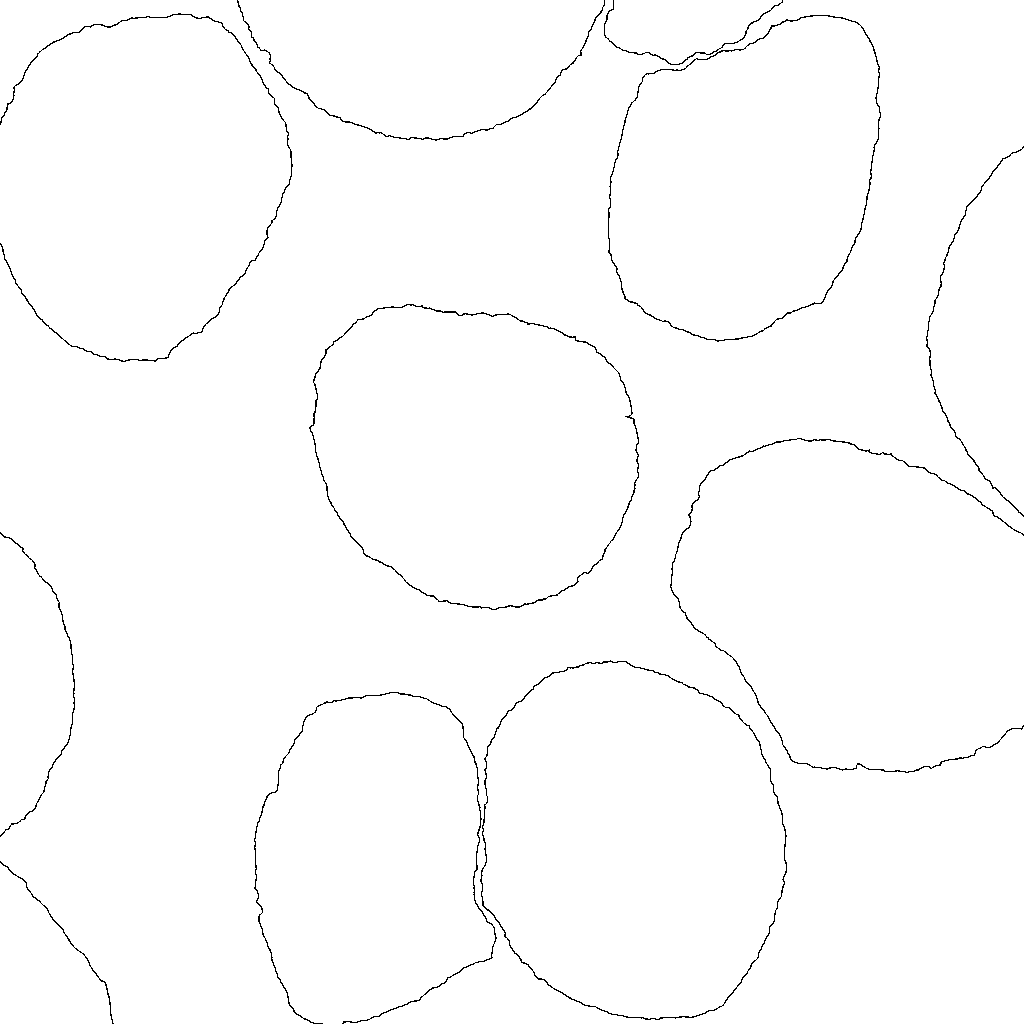

0011_1


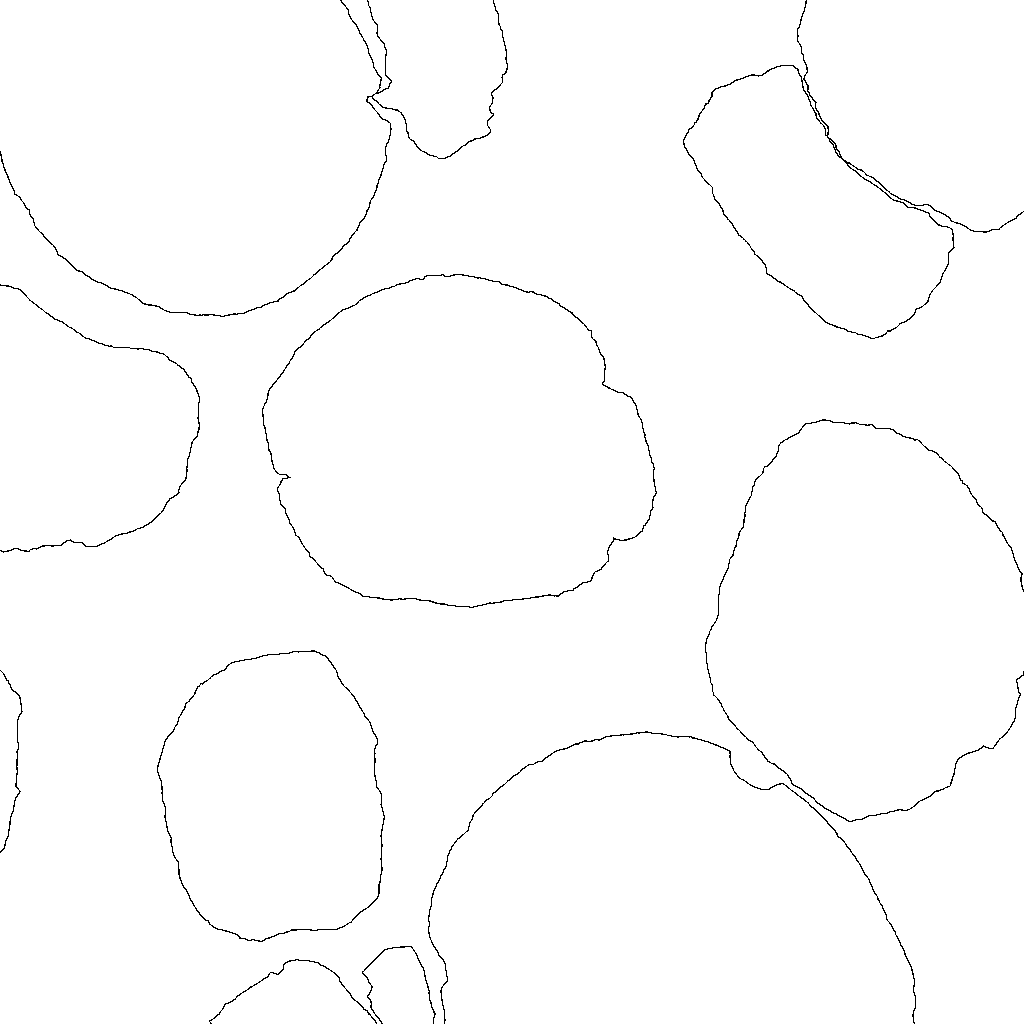

0022_1


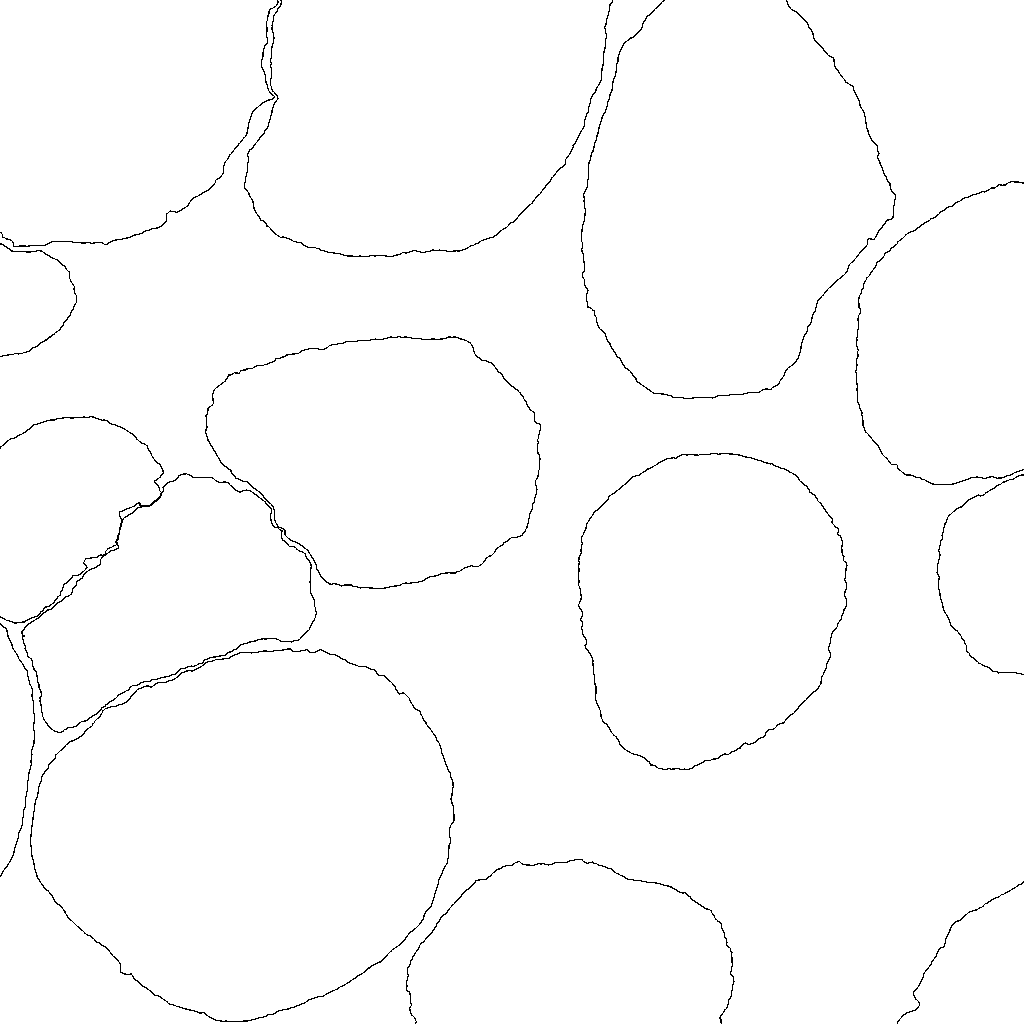

0025_1


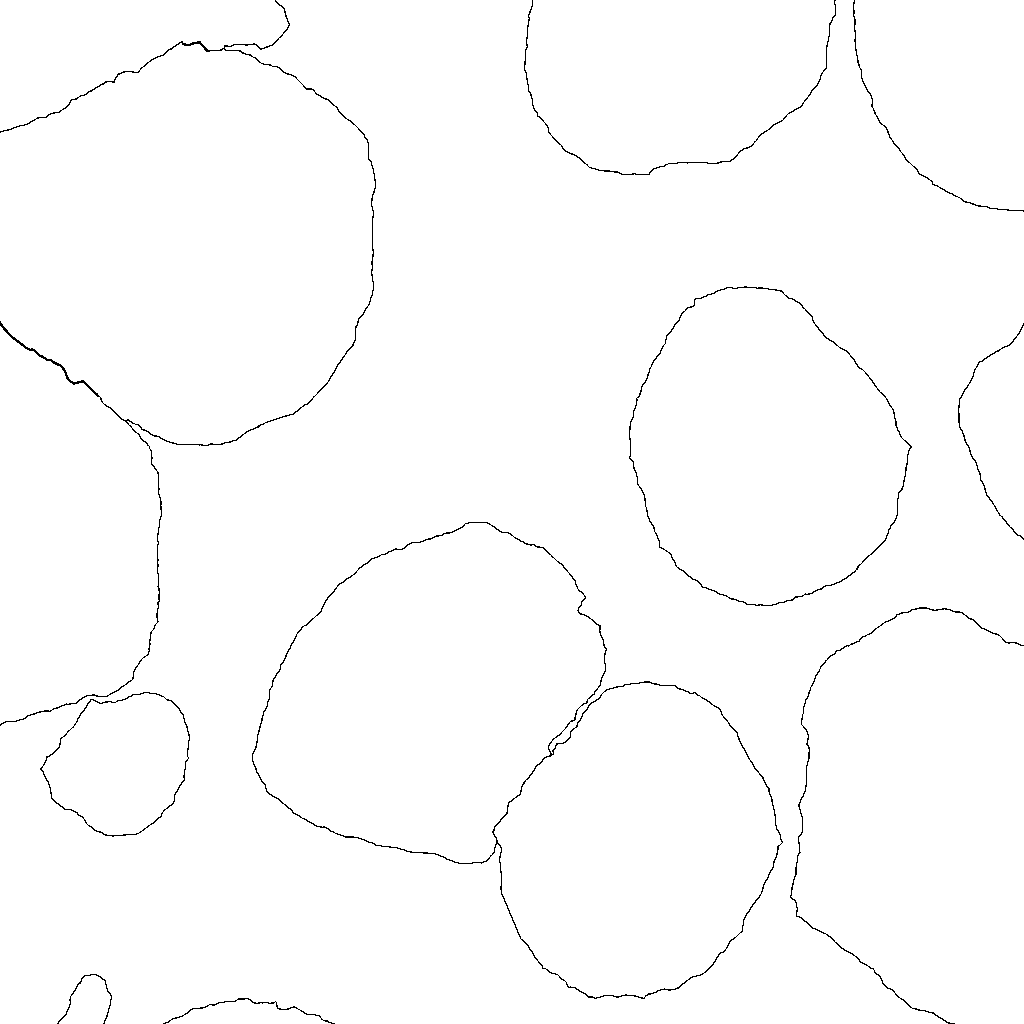

0007_1


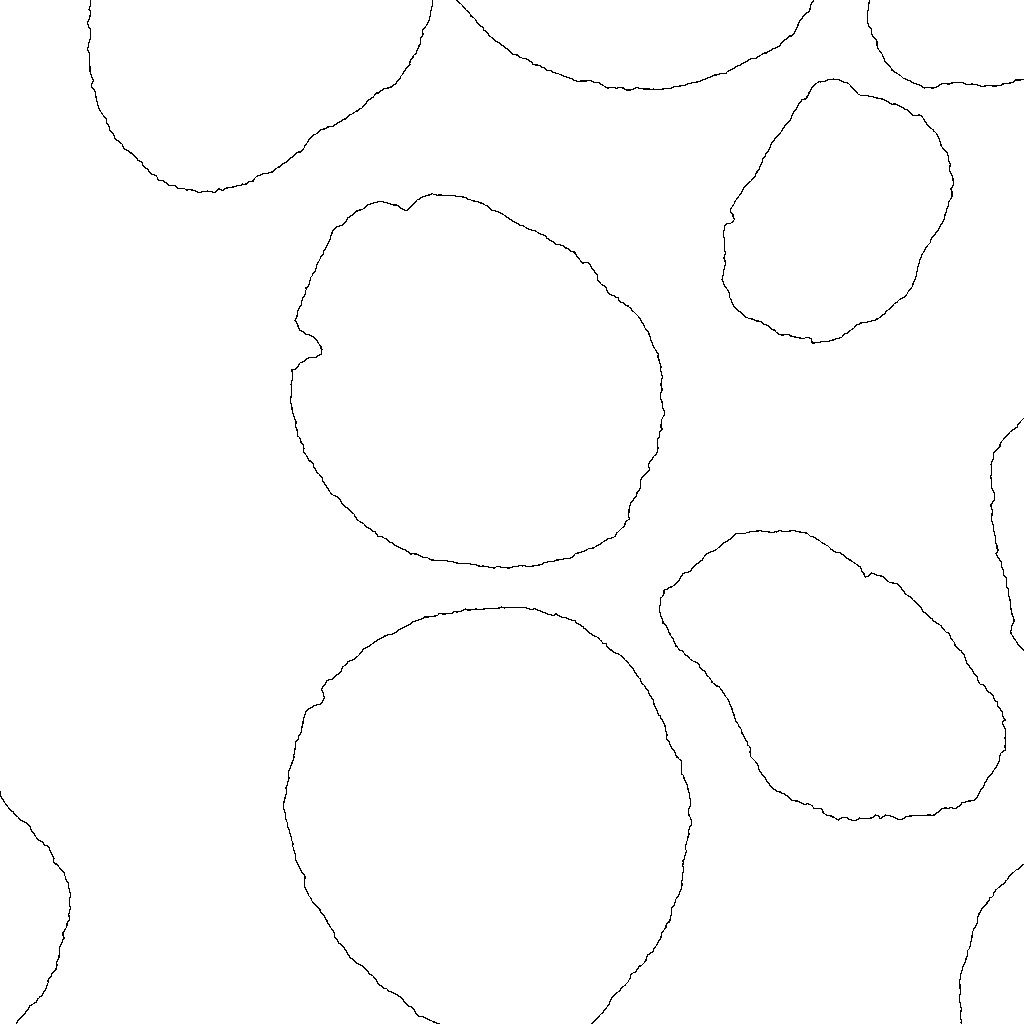

0030_1


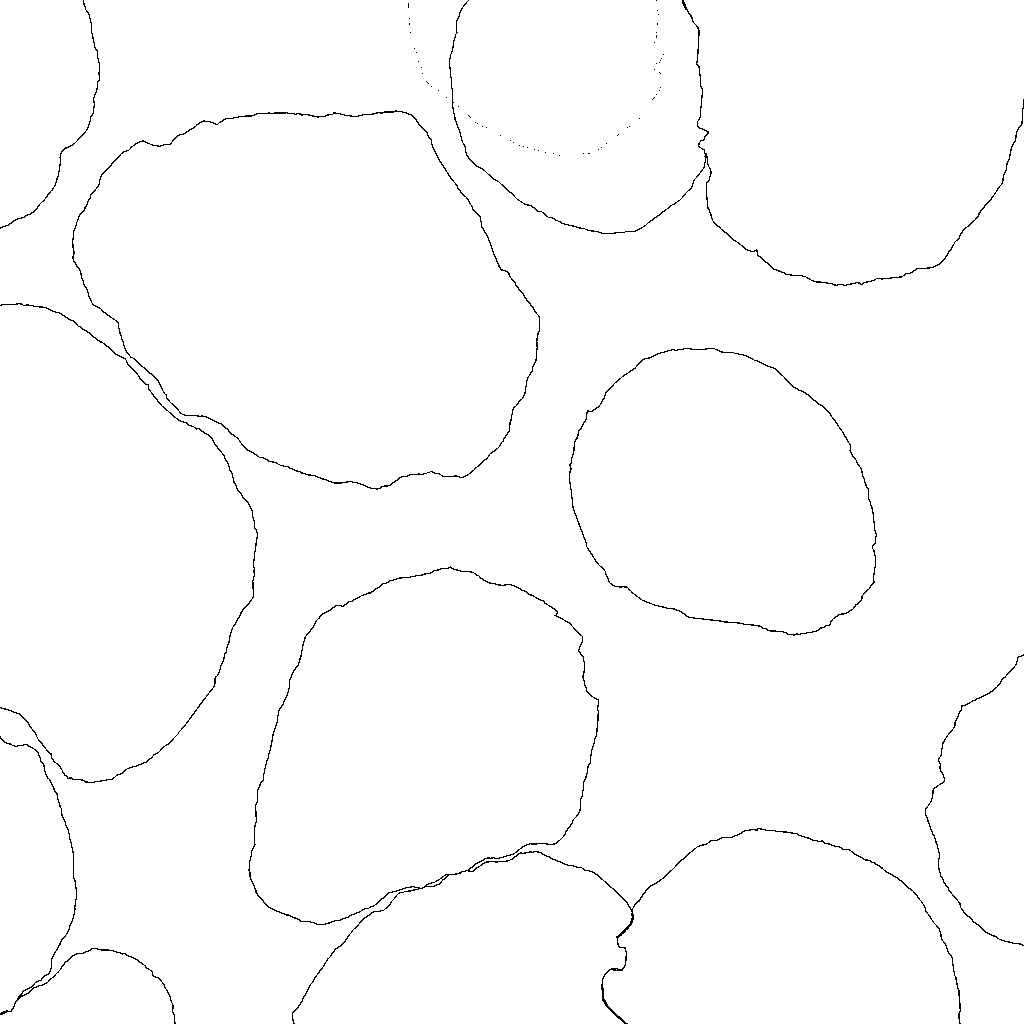

0013_1


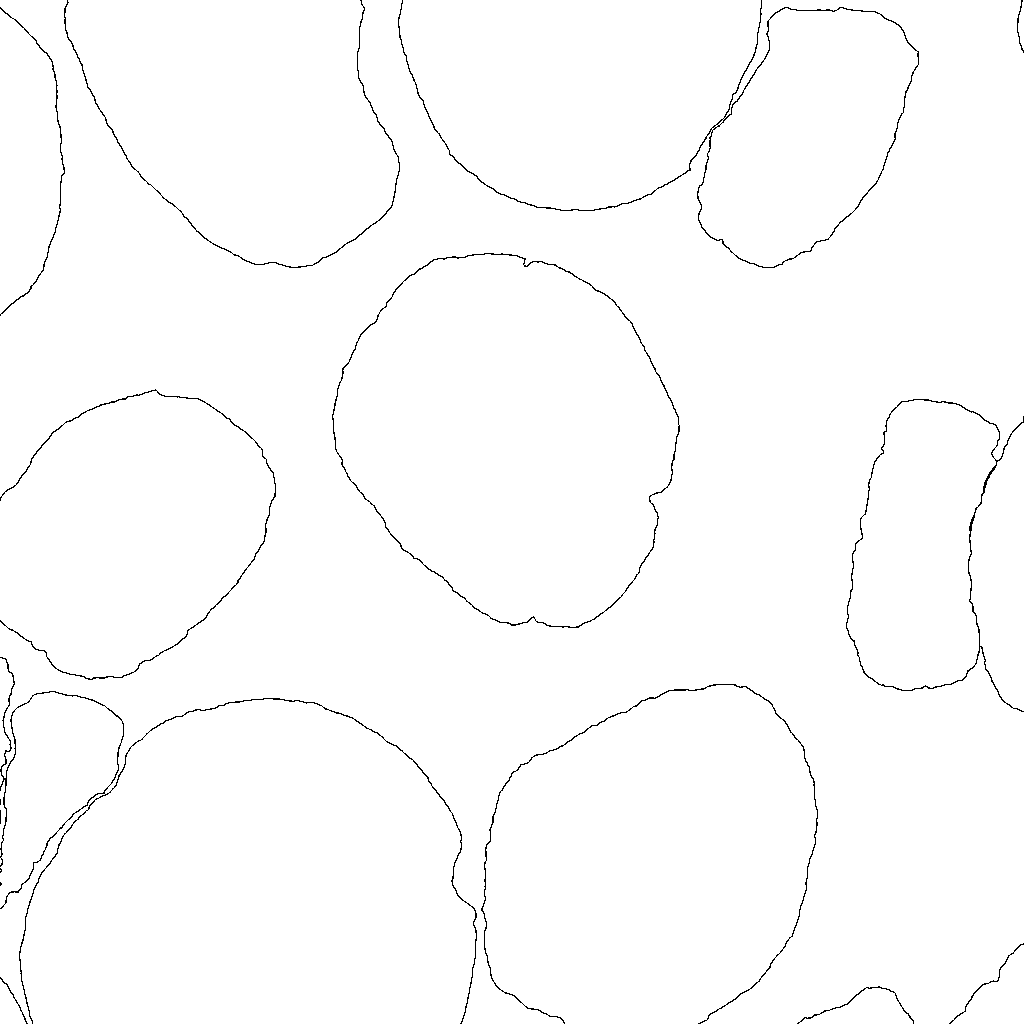

0021_1


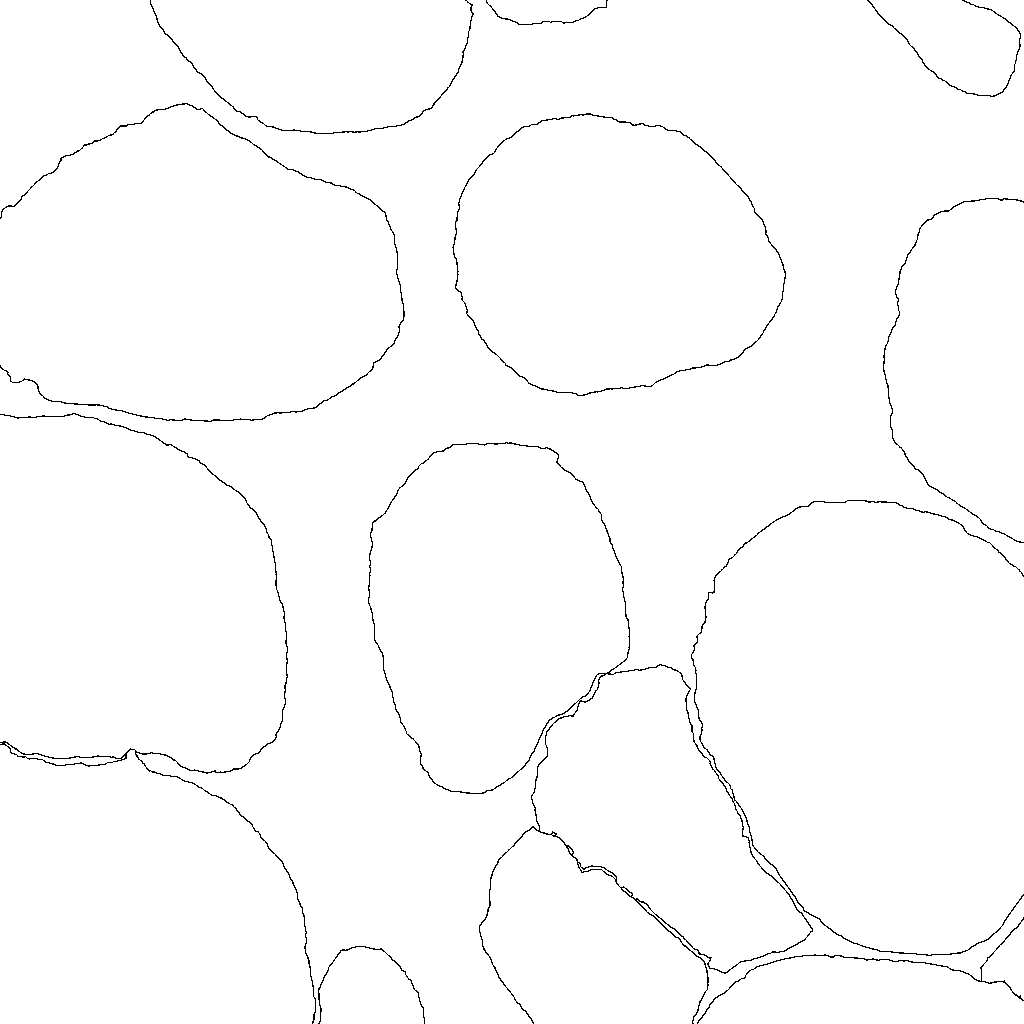

0068_1_1565791505_38


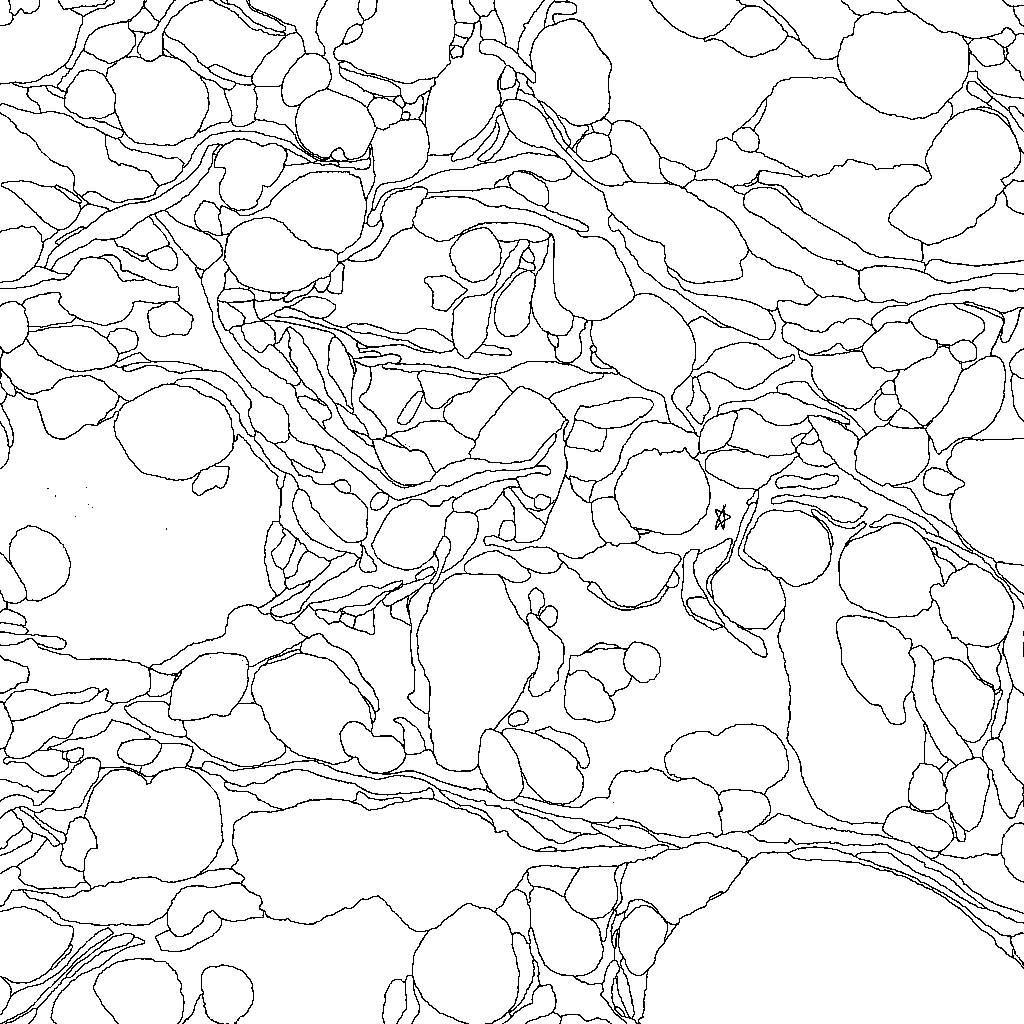

0111_1_1565791505_32


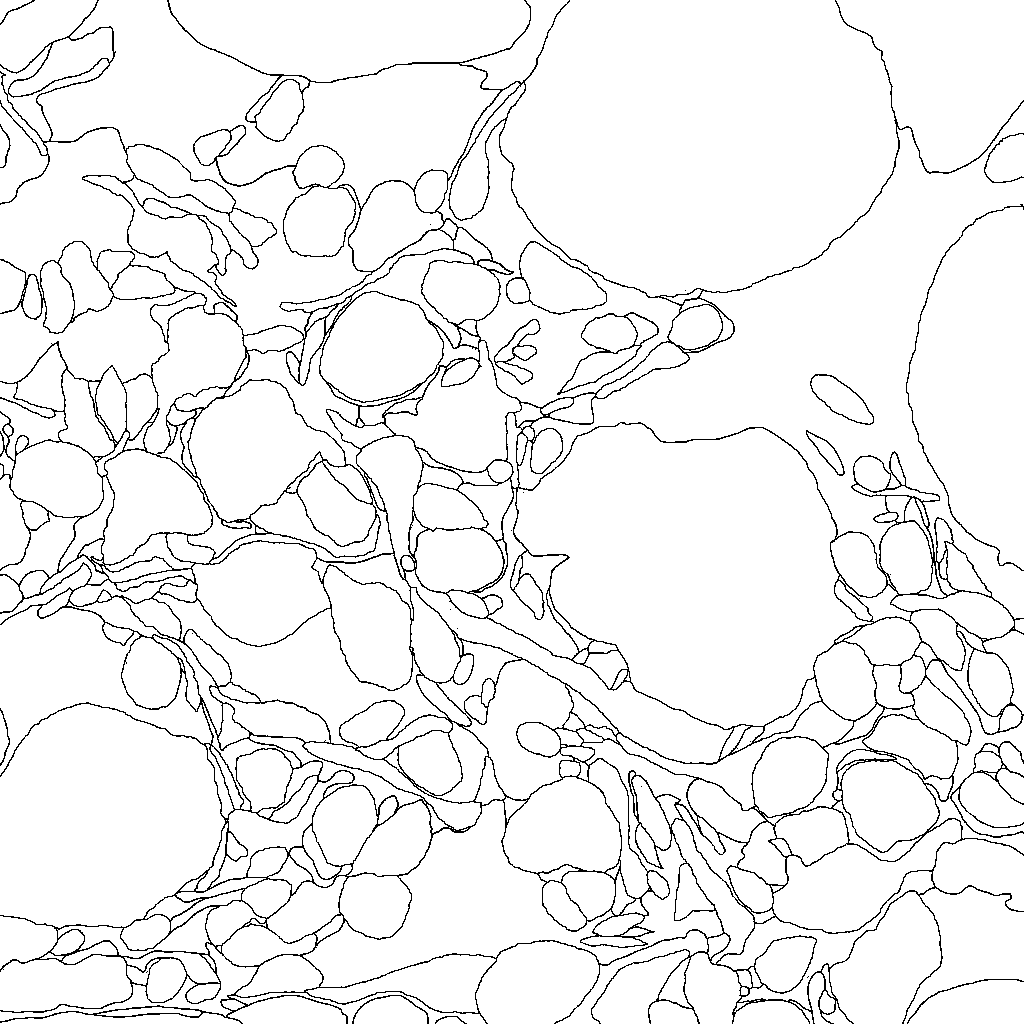

0108_1_1565791505_39


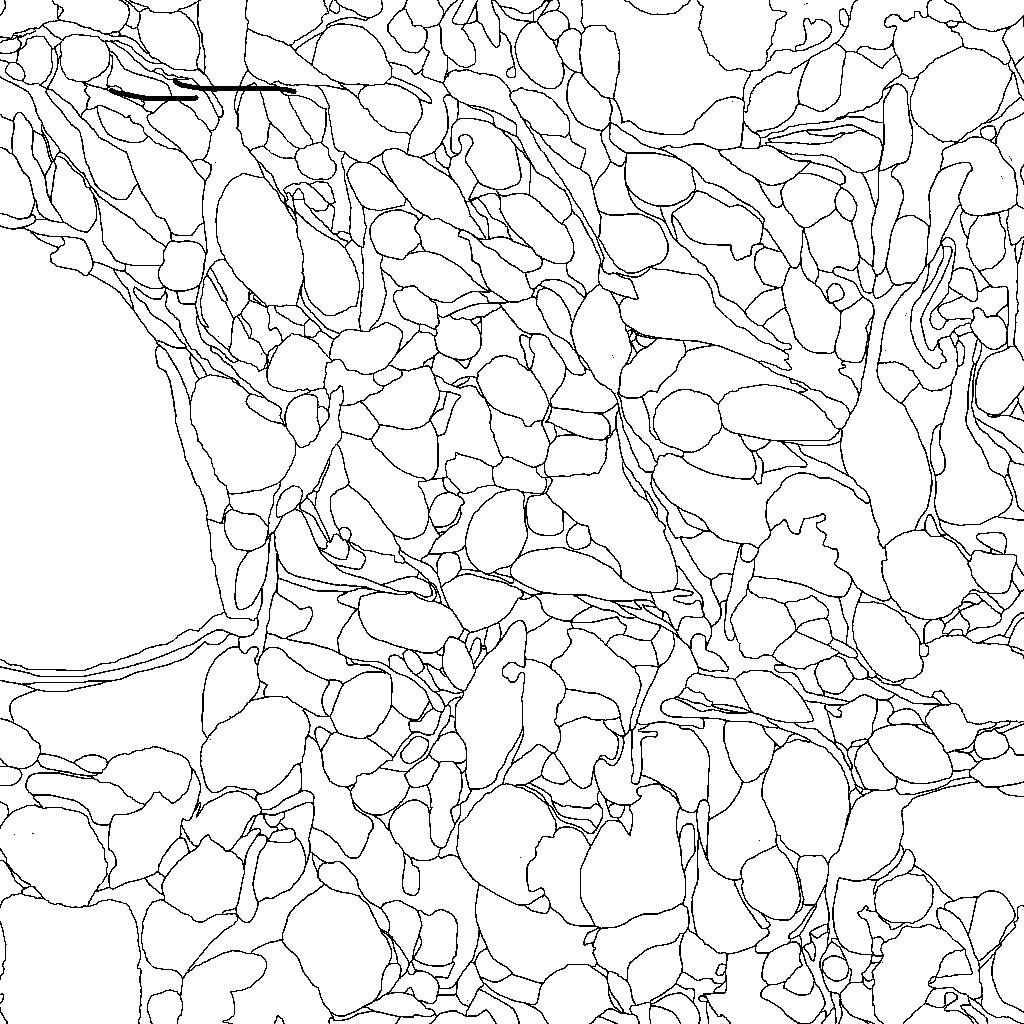

0114_1_1565791505_62


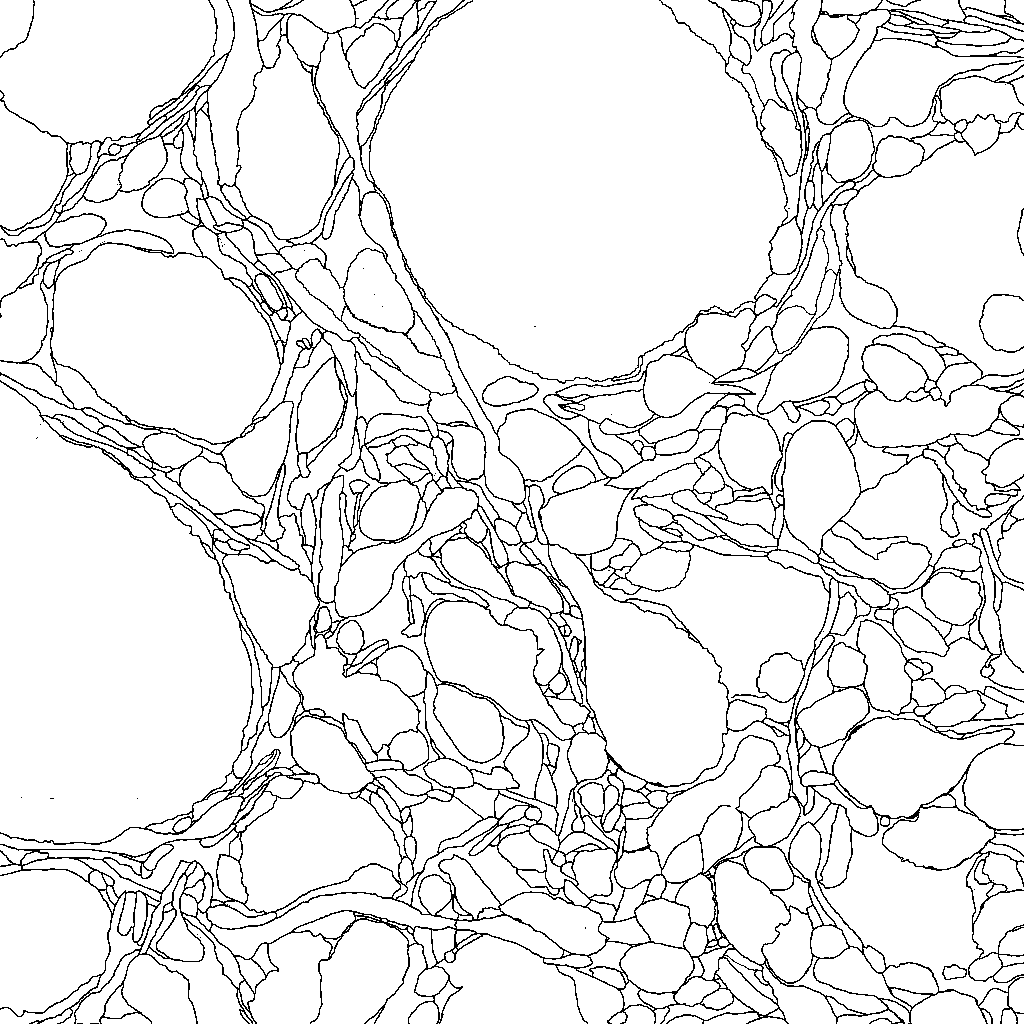

0109_1_1565791505_68


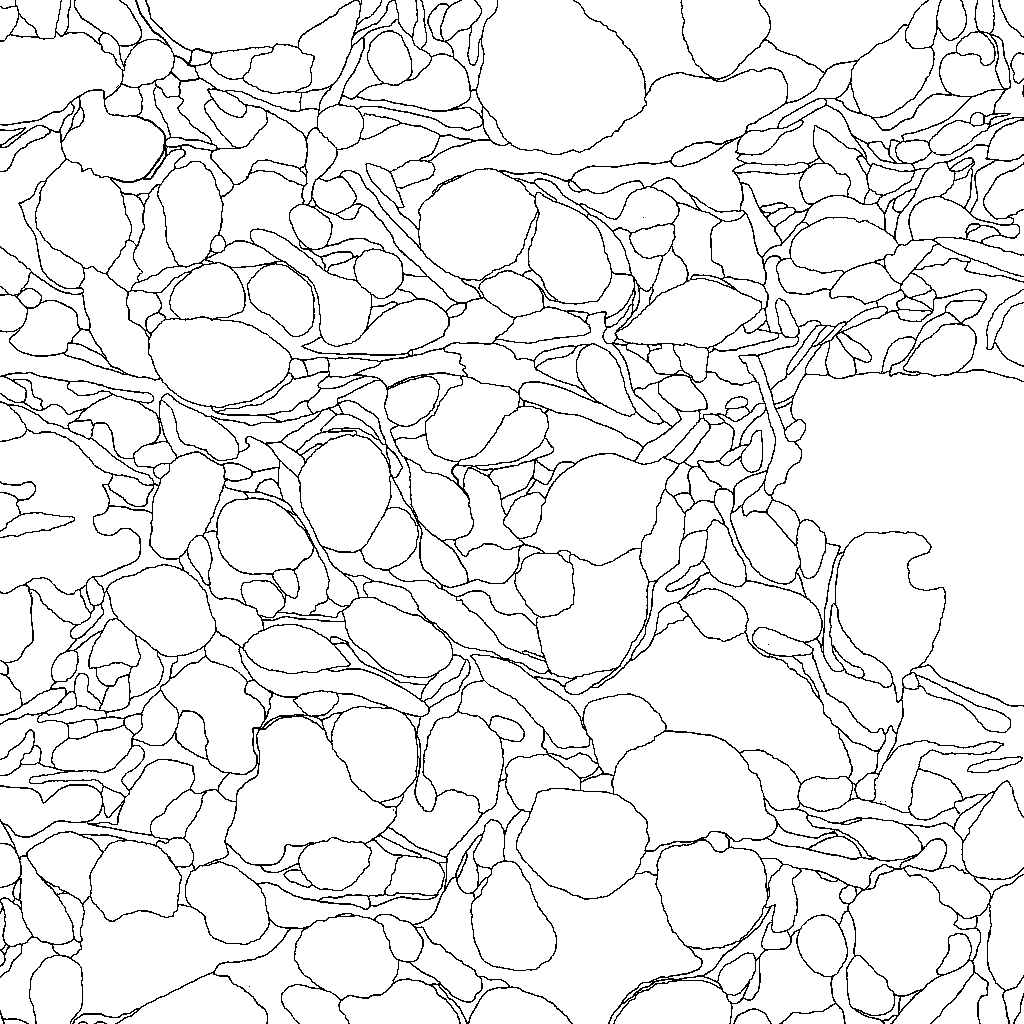

0124_1_1565791505_31


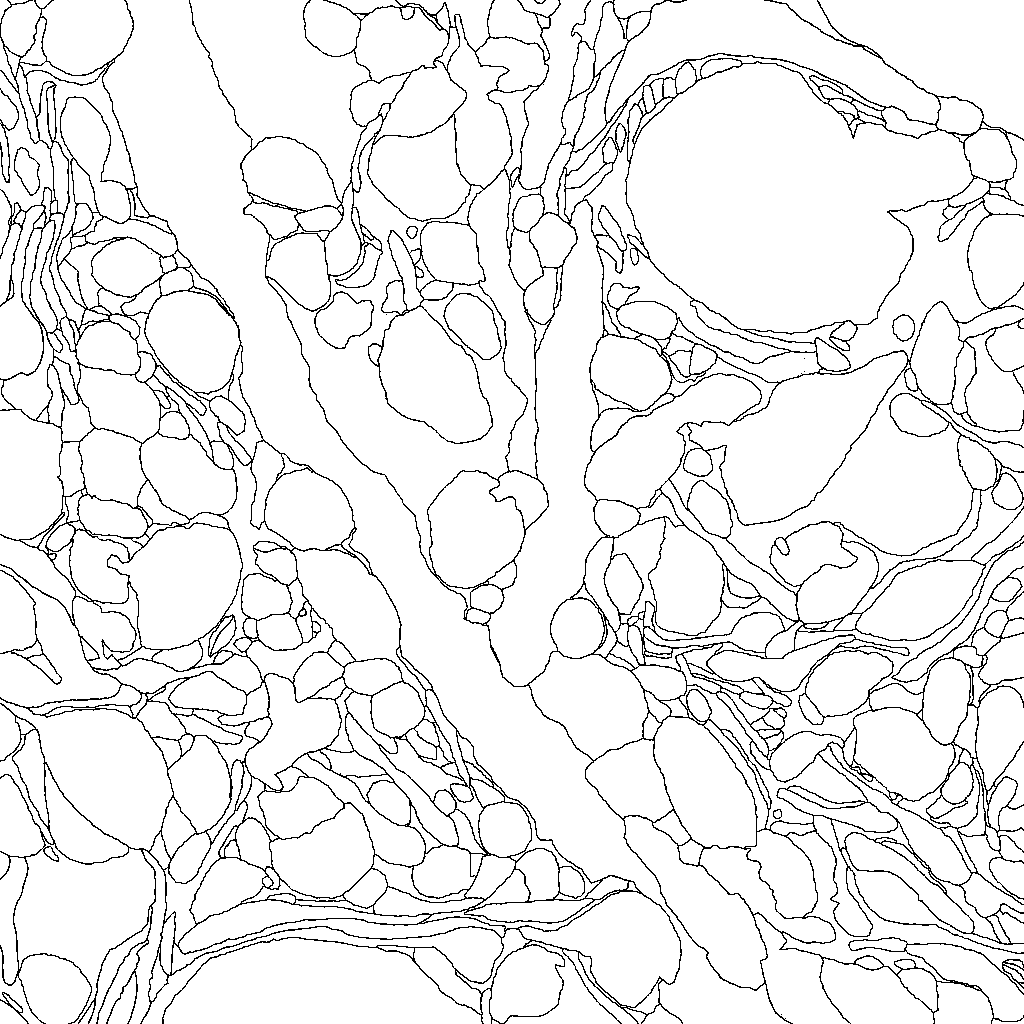

0070_1_1565791505_42


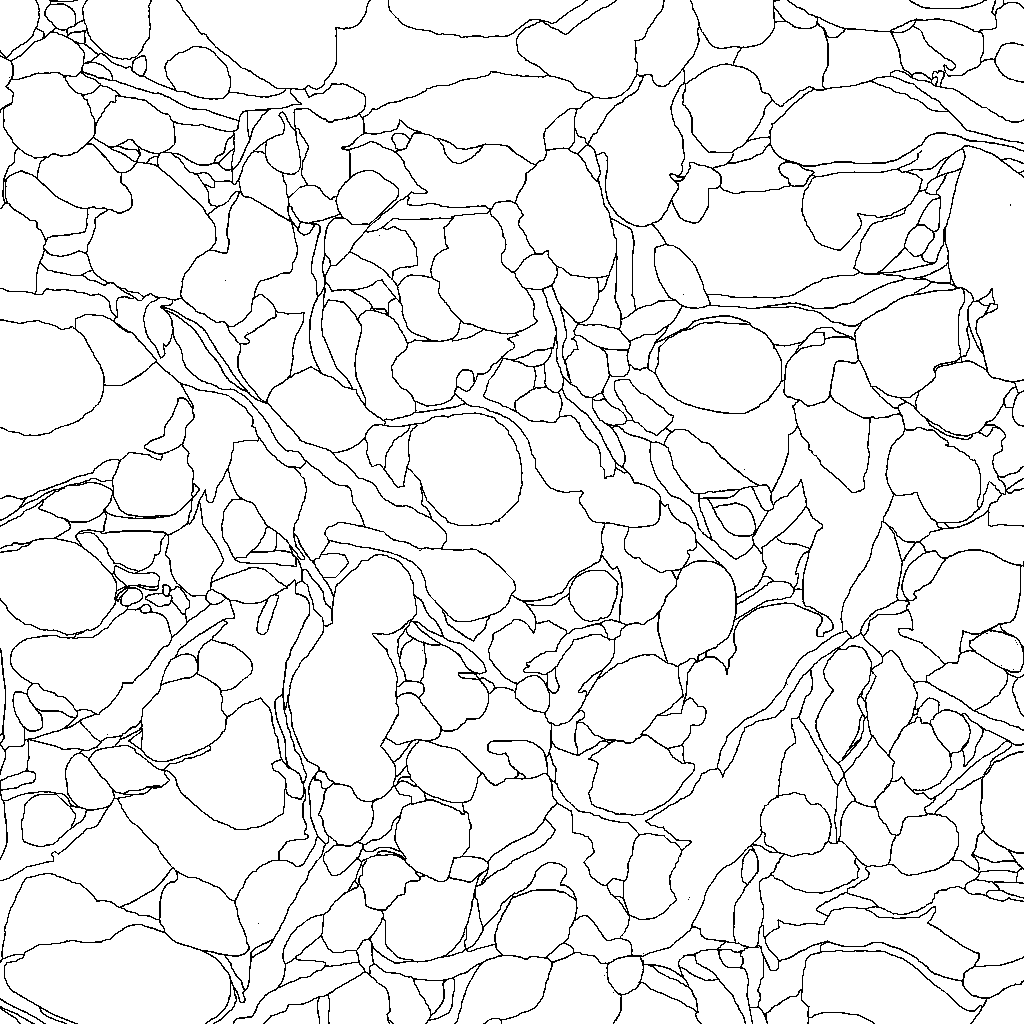

0105_1_1565791505_14


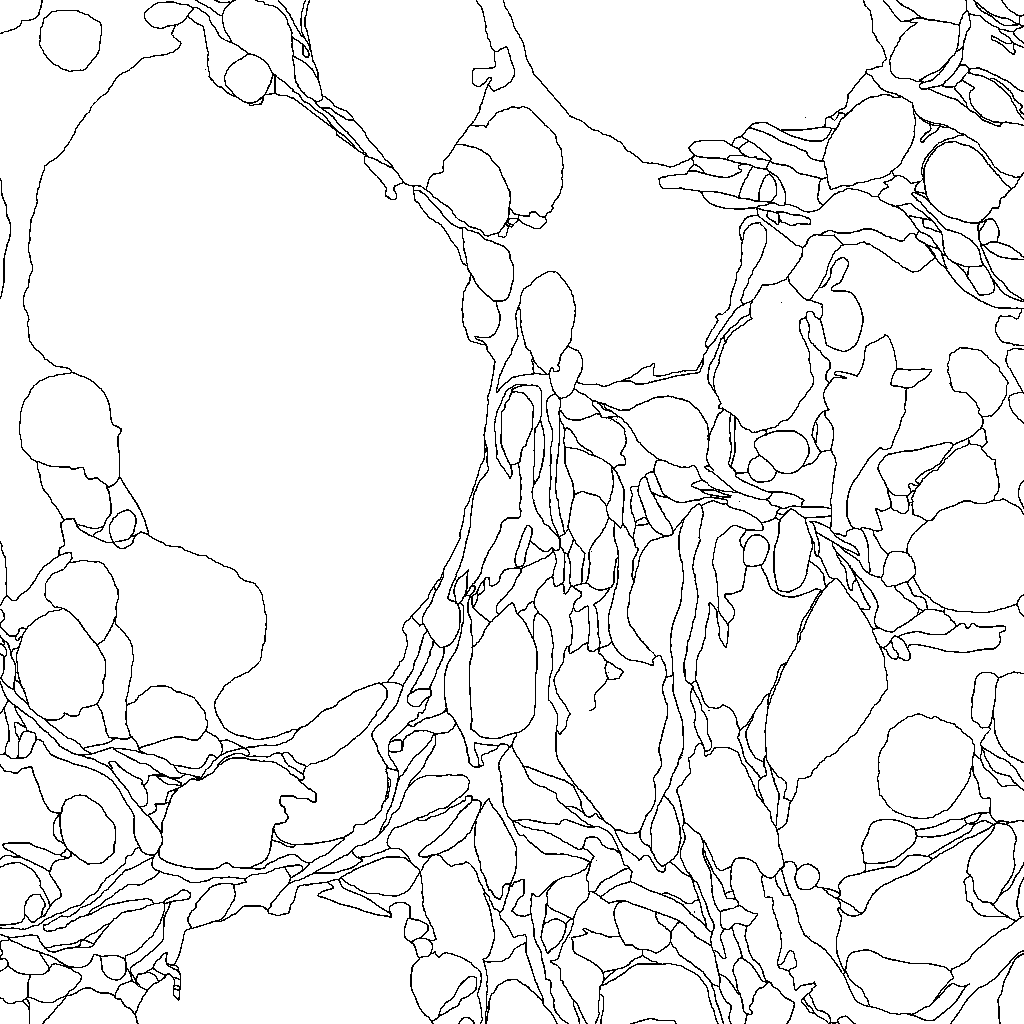

0129_1_1565791505_77


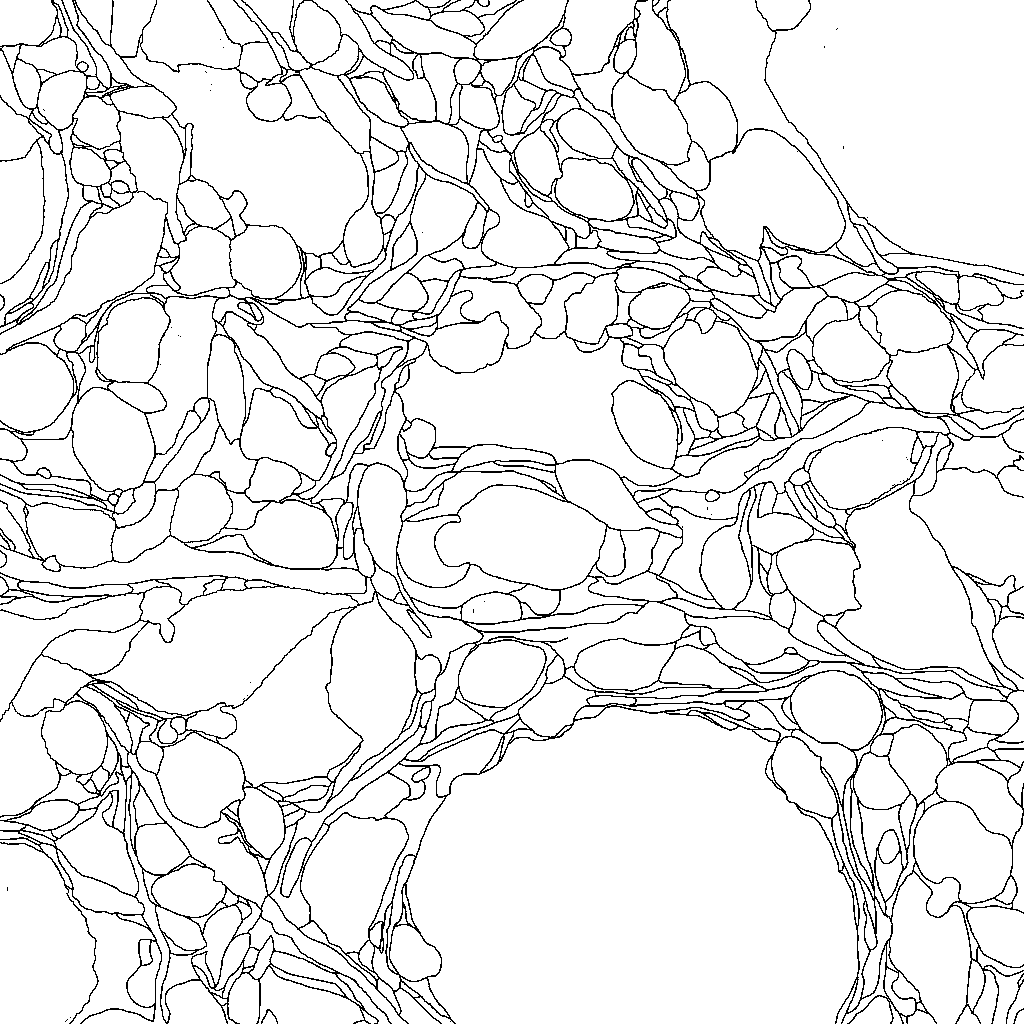

0129_1_1565791505_28


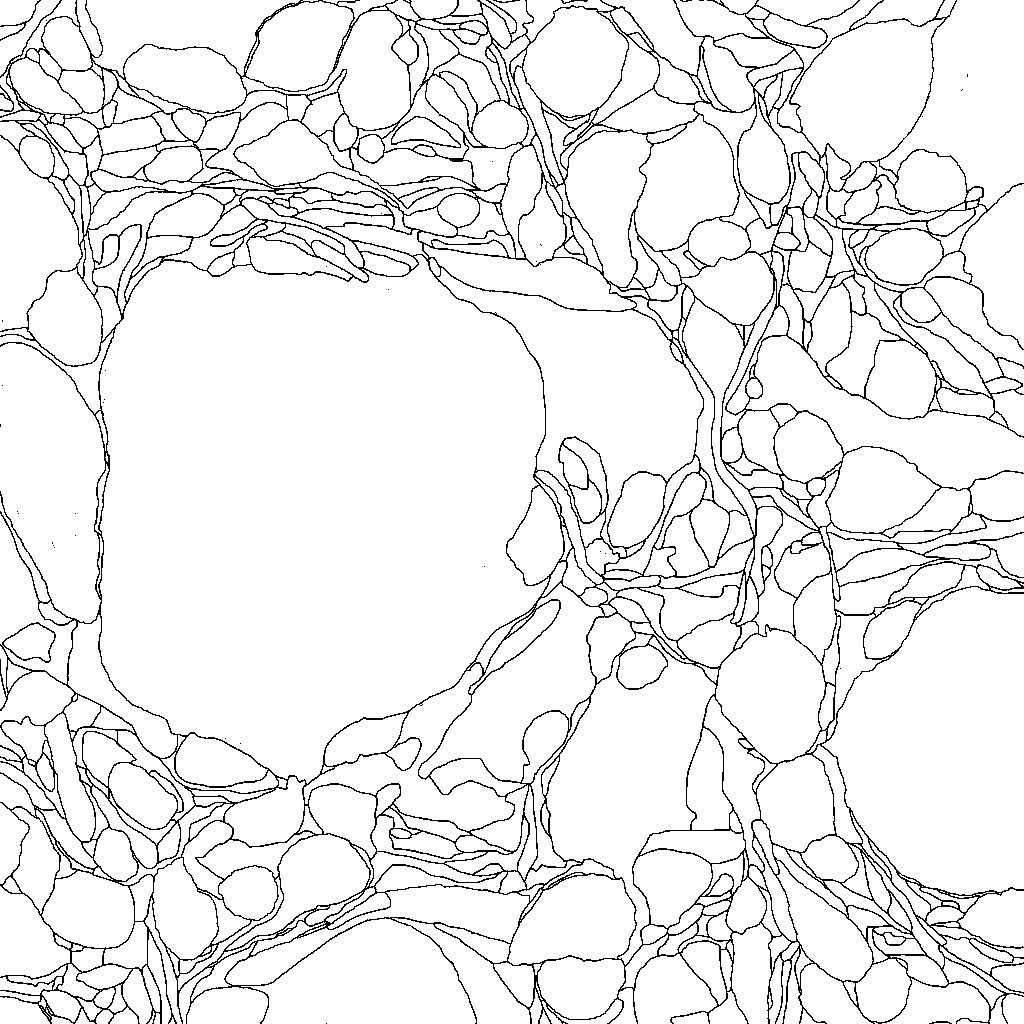

0130_1_1565791505_61


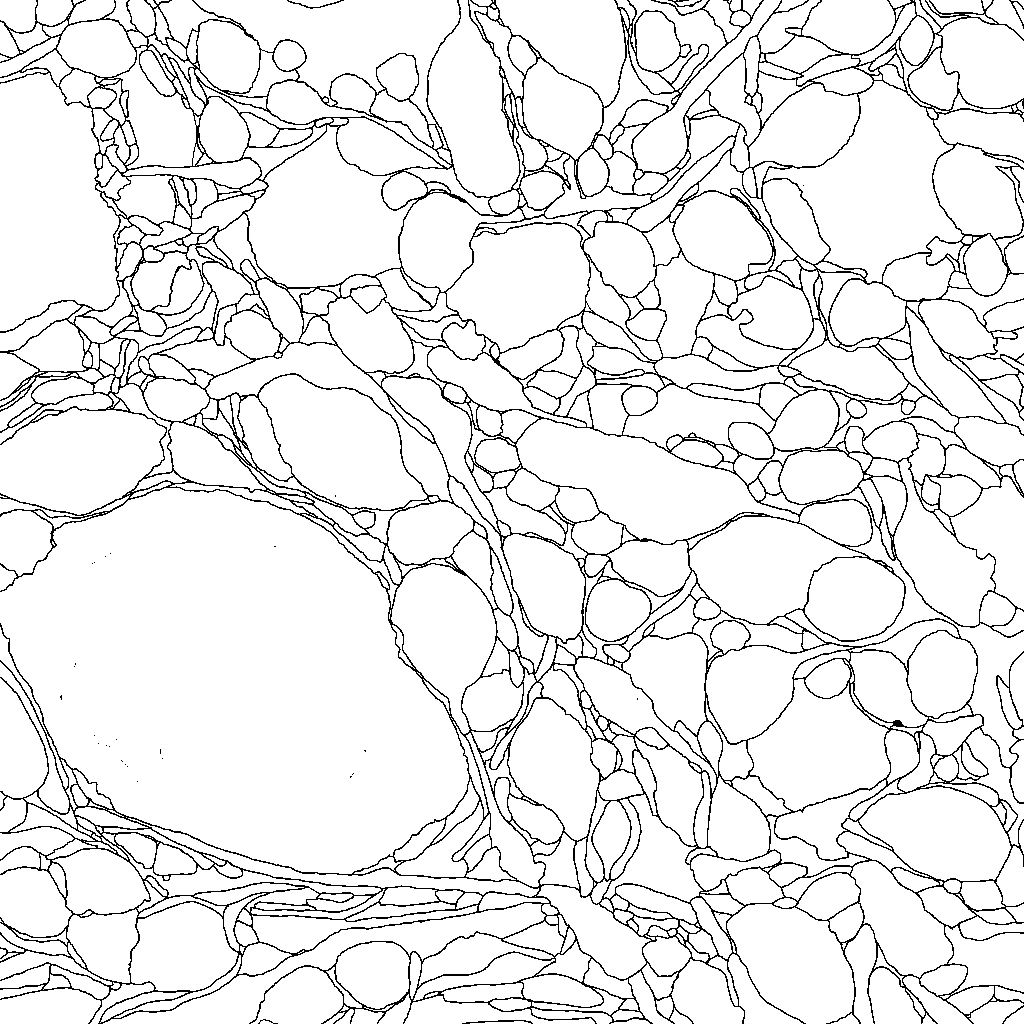

0134_1_1565791505_24


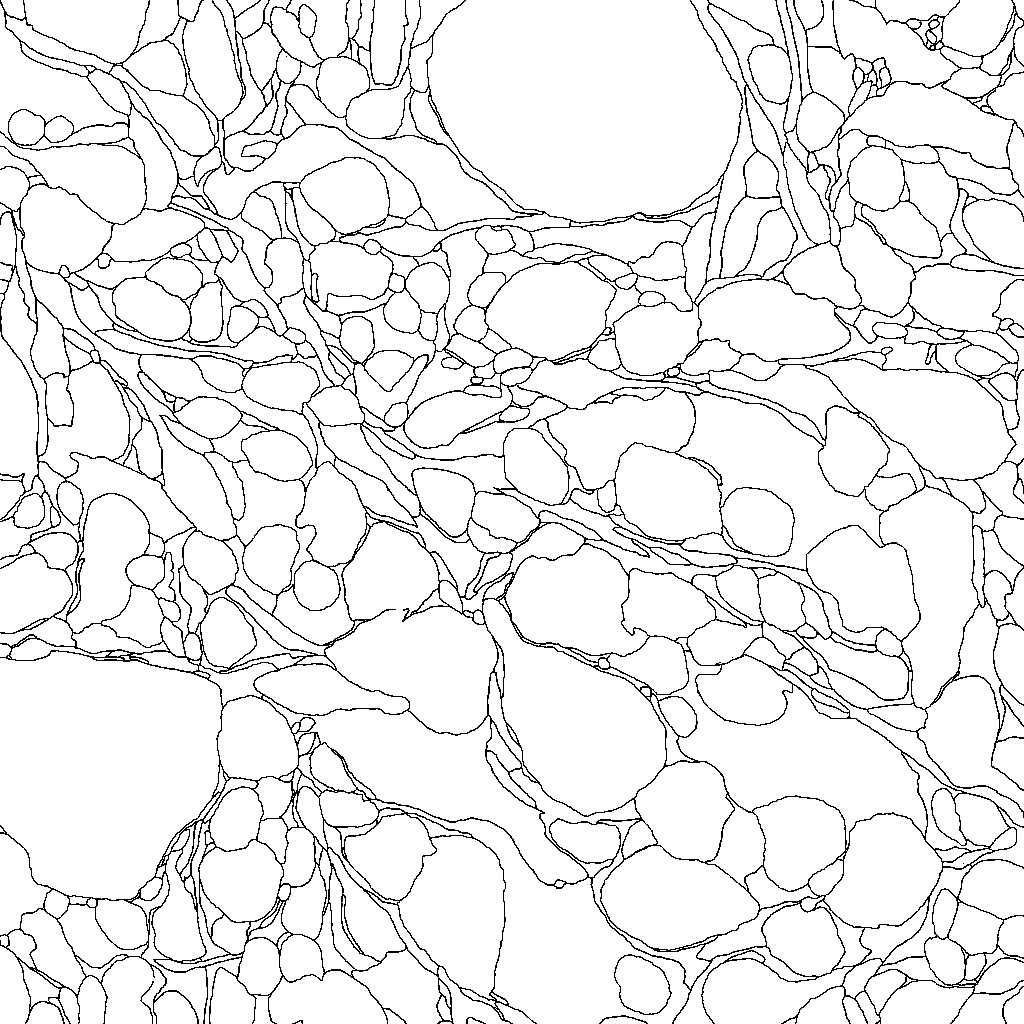

0131_1_1565791505_28


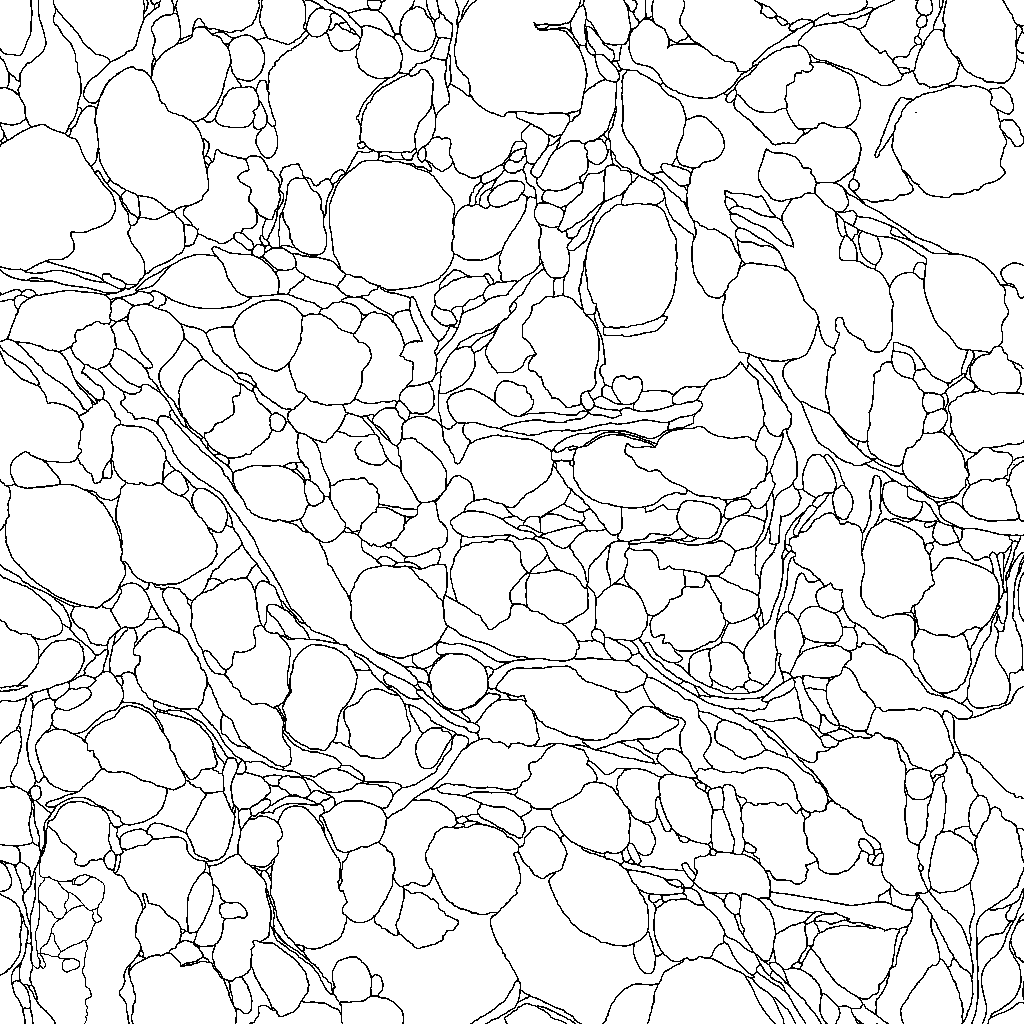

0134_1_1565791505_41


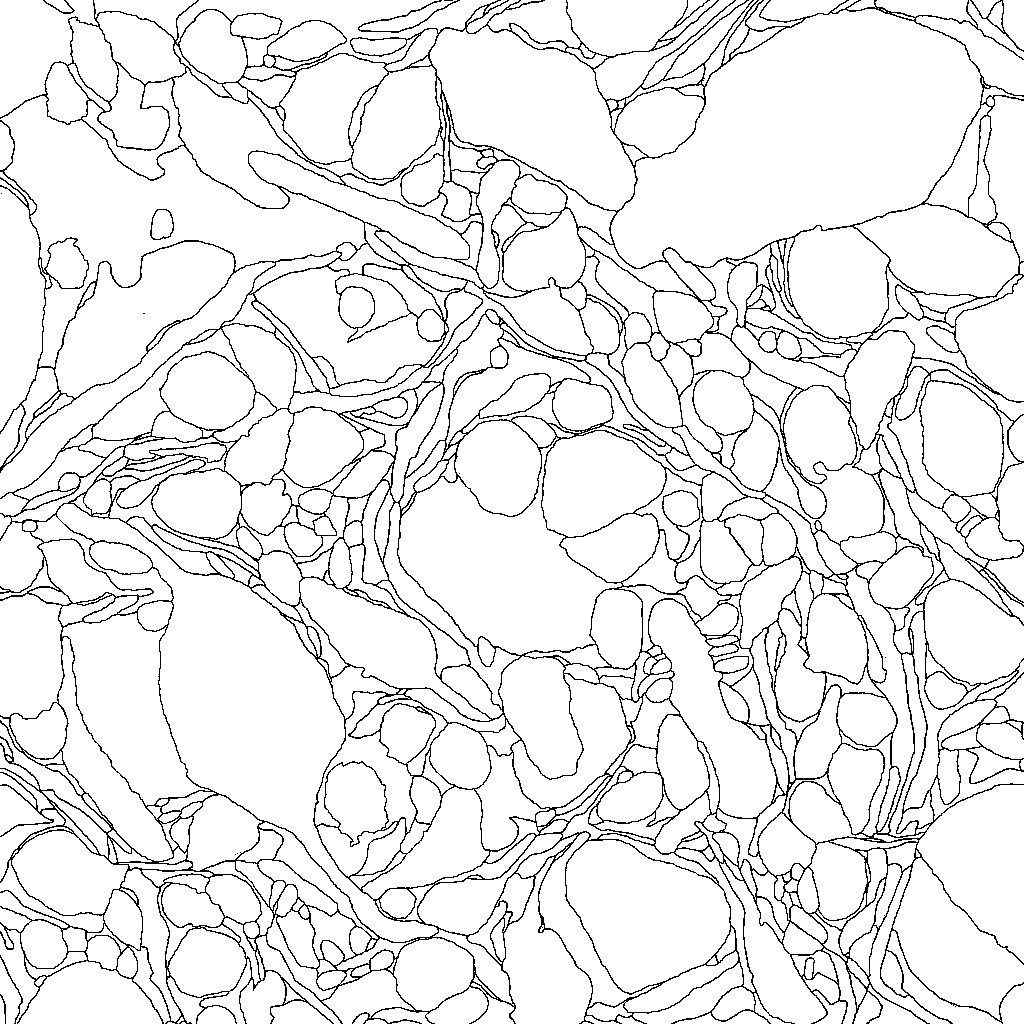

0133_1_1565791505_67


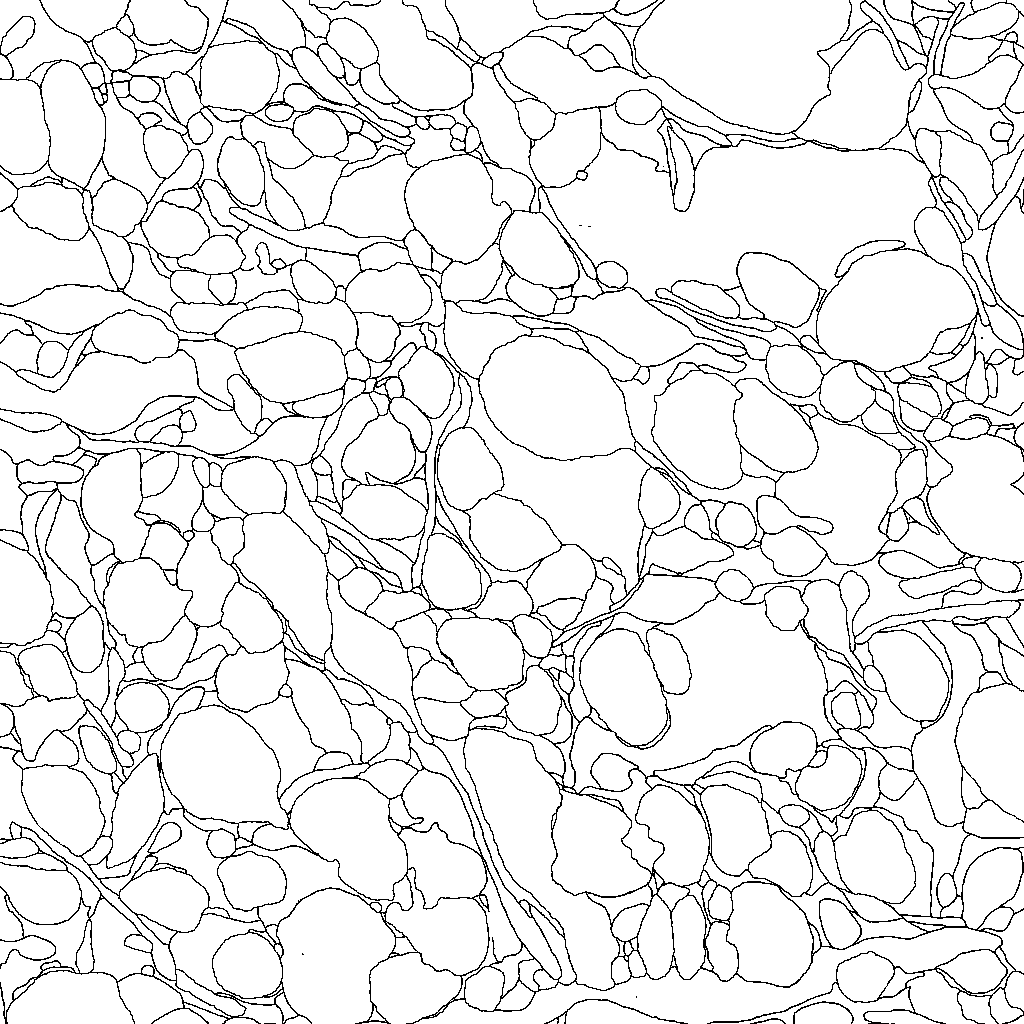

0148_1_1565791505_22


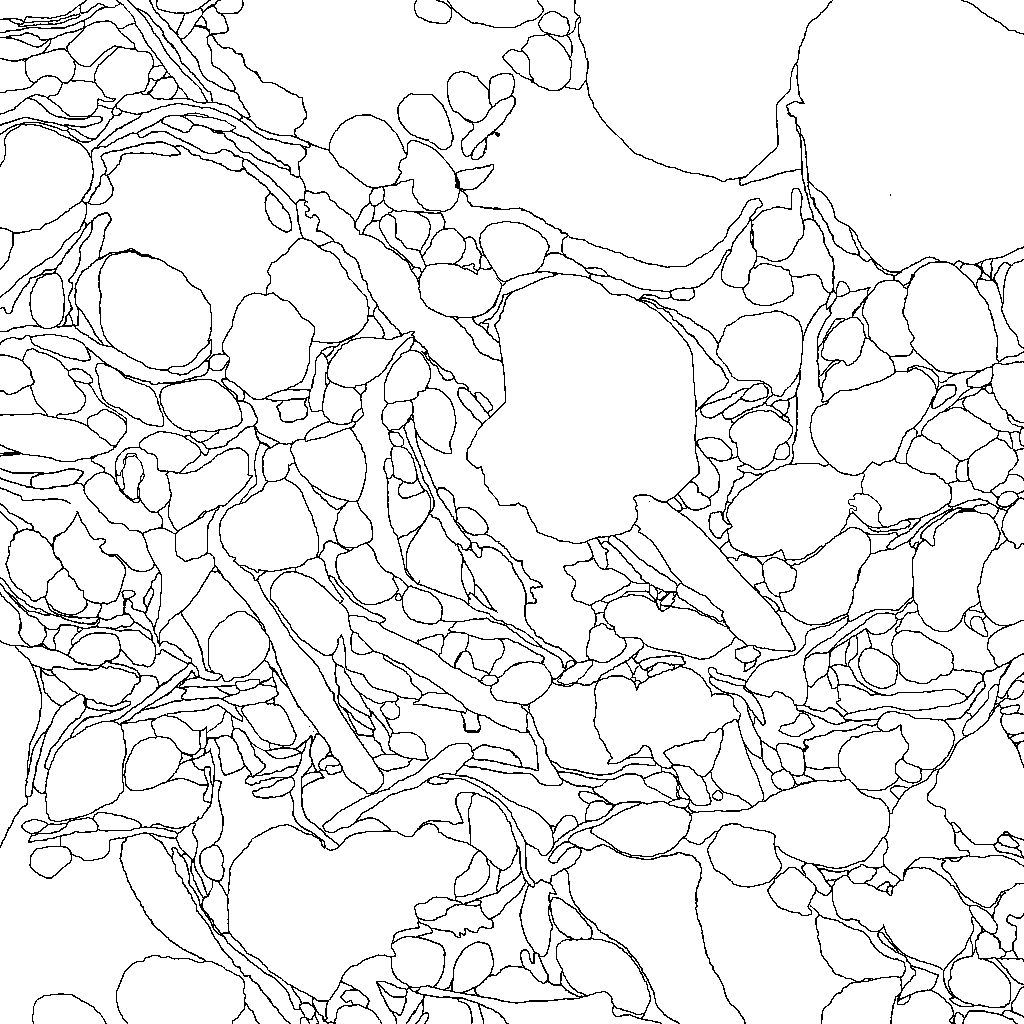

0137_1_1565791505_94


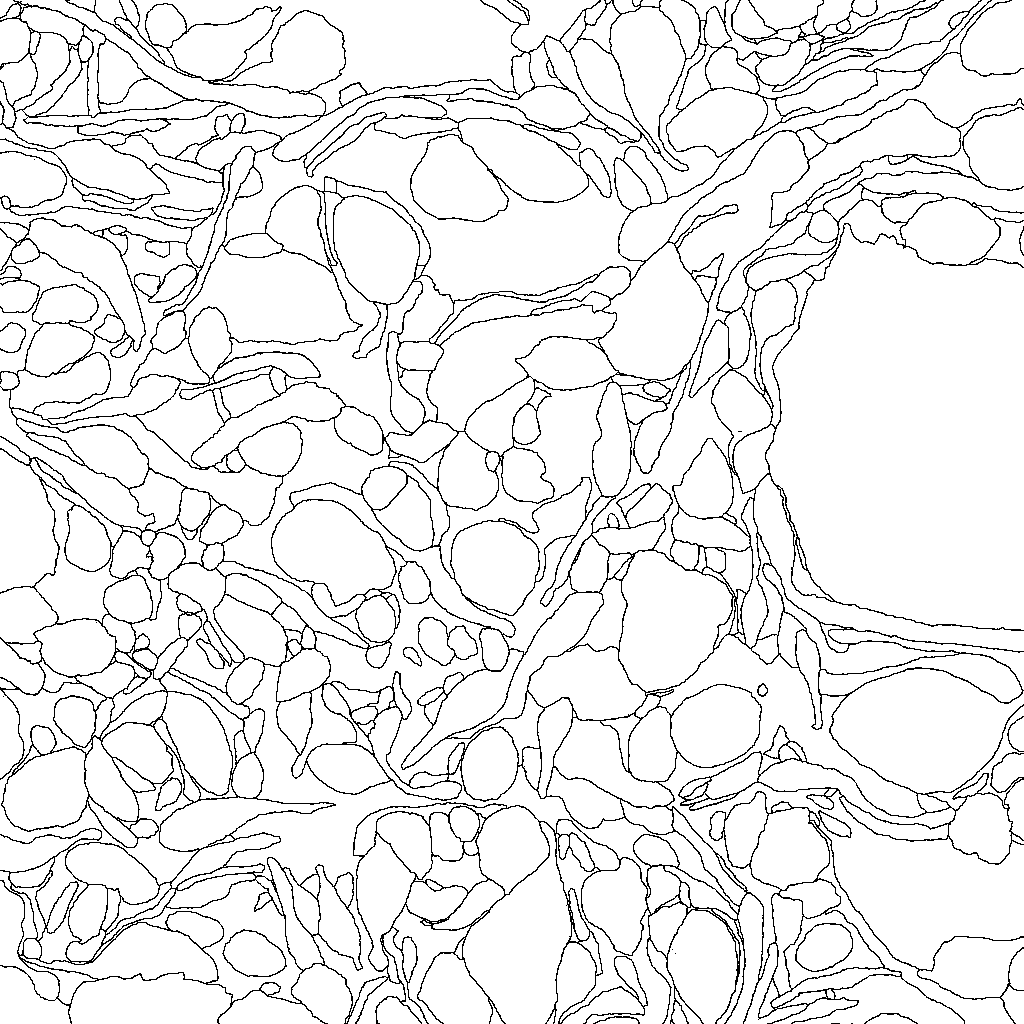

0152_1_1565791505_58


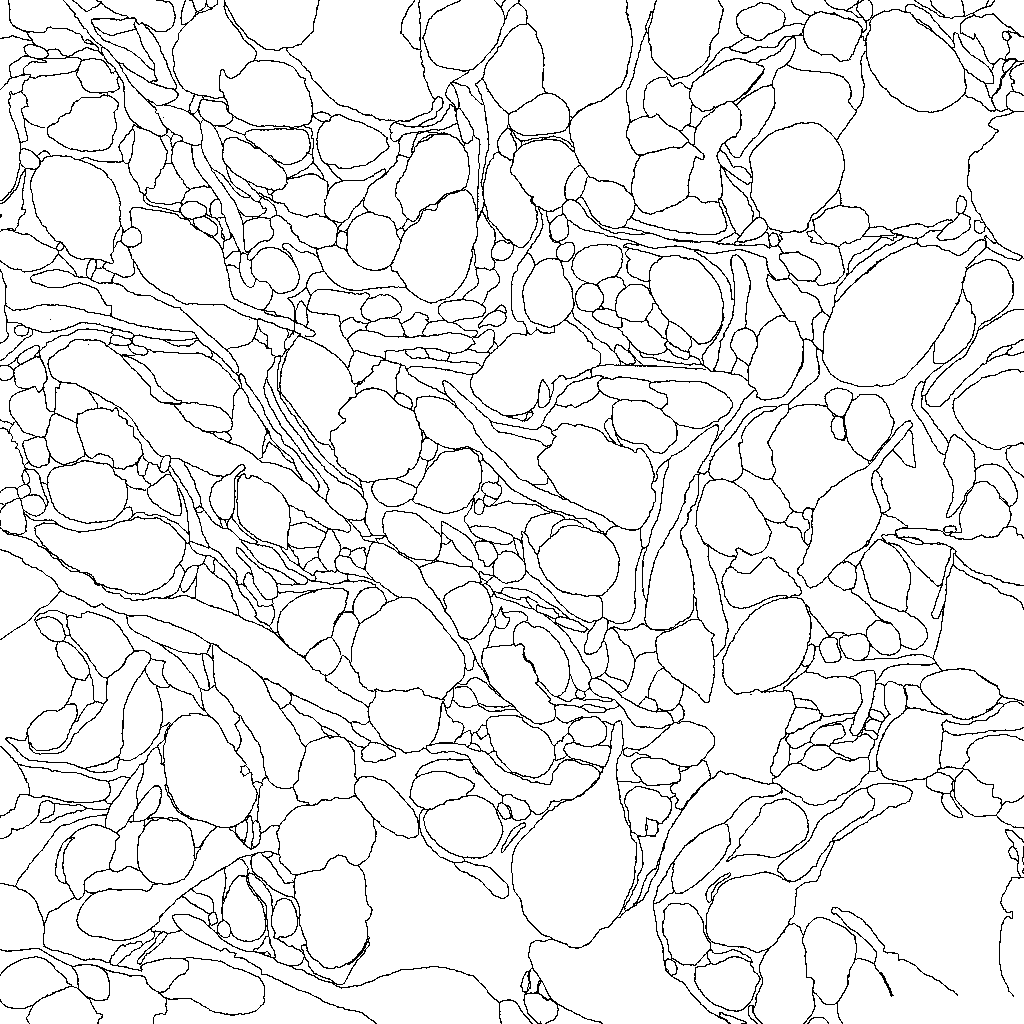

0142_1_1565791505_78


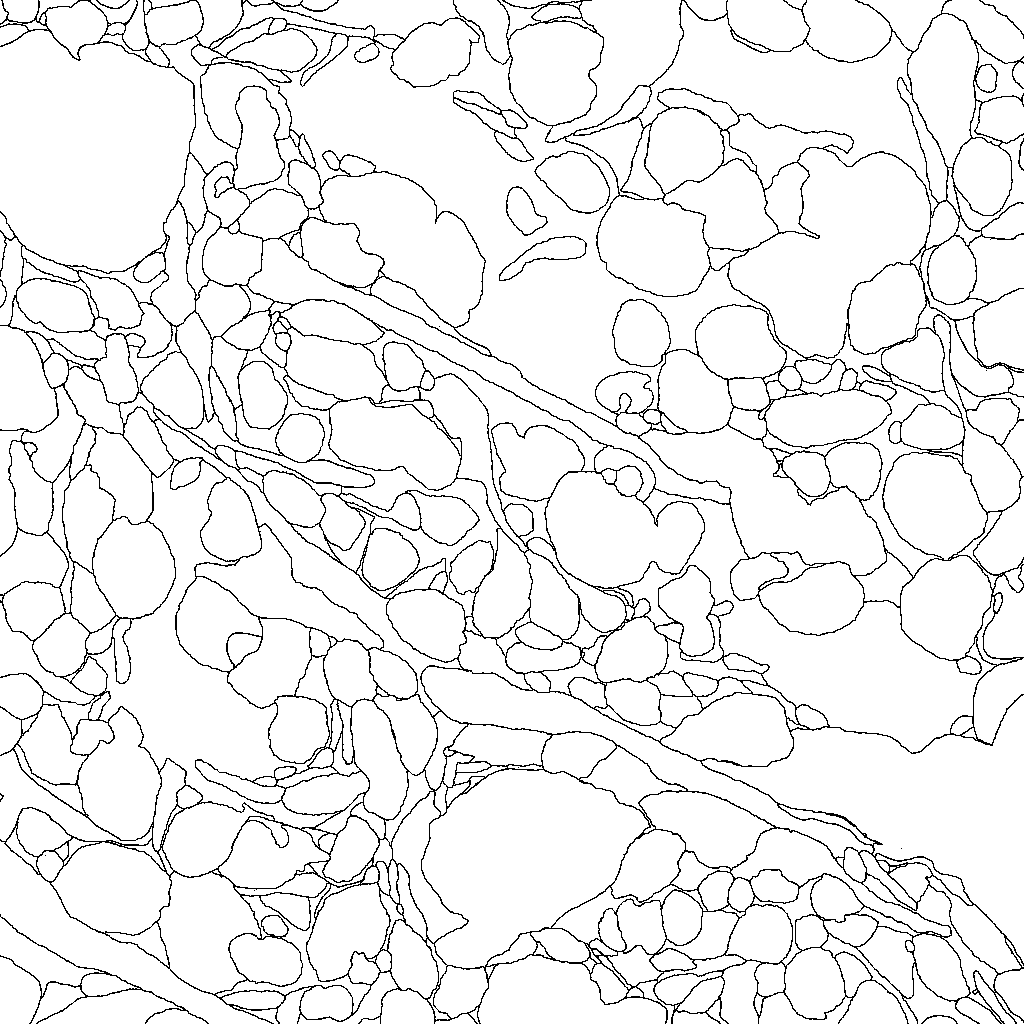

0151_1_1565791505_6


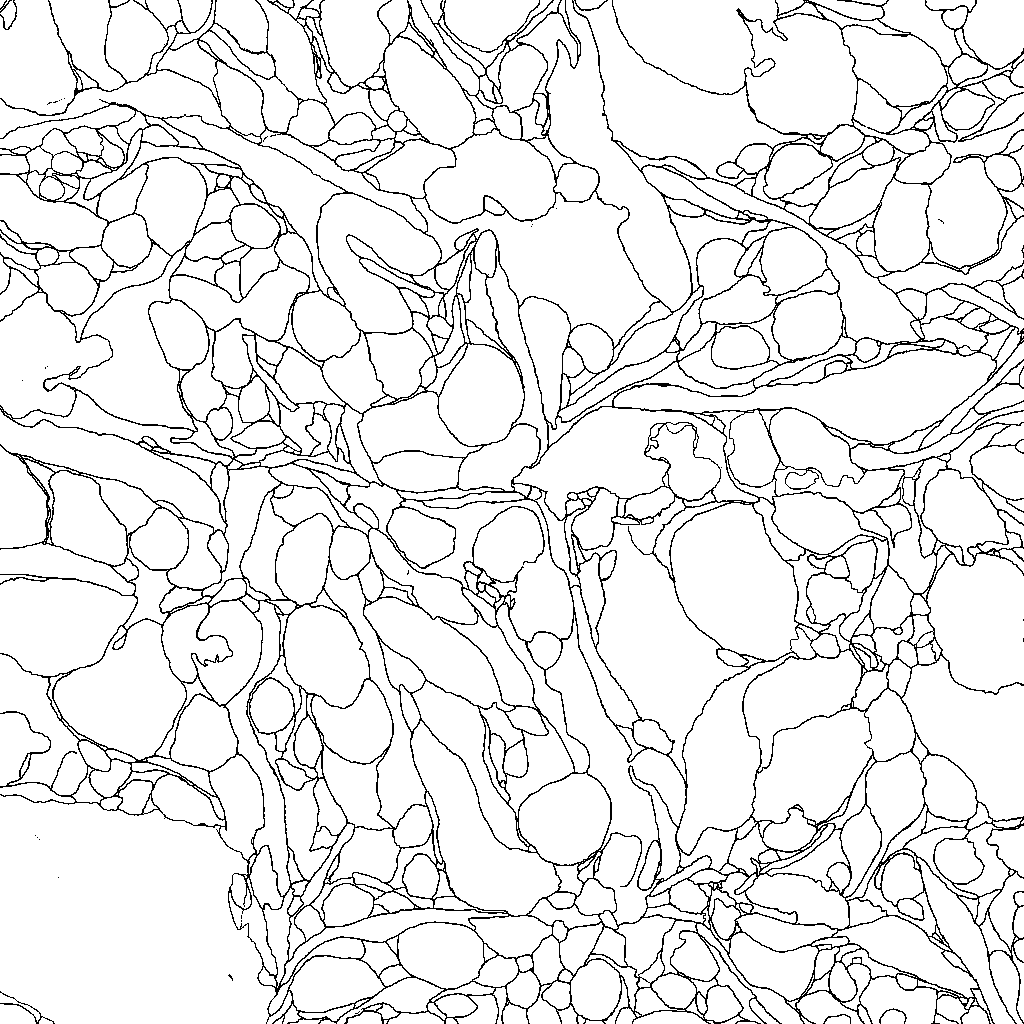

In [0]:
import cv2
from os import listdir
from os.path import join,splitext
from google.colab.patches import cv2_imshow
names = [splitext(x)[0]for x in listdir(join('/content/drive/My Drive/UNET/simple_train_label/U-RISC_OPEN_DATA_SIMPLE/labels'))]
for i in range(len(names)):
  print(names[i])
  img = cv2.imread(join('/content/drive/My Drive/UNET/simple_train_label/U-RISC_OPEN_DATA_SIMPLE/labels_01',names[i]+'.tiff'),0)
  
  #img = cv2.resize(img,(1024,1024),interpolation=cv2.INTER_CUBIC)   #dsize=（2*width,2*height）
  #ret,img = cv2.threshold(img,242,1,cv2.THRESH_BINARY)
  
  cv2_imshow(img*255)
  #cv2.imwrite(join('/content/drive/My Drive/UNET/simple_train_label/U-RISC_OPEN_DATA_SIMPLE/labels_01/',names[i]+'.tiff'),img)

In [0]:
import cv2
from os import listdir
from os.path import join,splitext
from google.colab.patches import cv2_imshow
names = [splitext(x)[0]for x in listdir(join('/content/drive/My Drive/UNET/simple_train_label/U-RISC_OPEN_DATA_SIMPLE/val'))]
for i in range(len(names)):
  print(names[i])
  img = cv2.imread(join('/content/drive/My Drive/UNET/simple_train_label/U-RISC_OPEN_DATA_SIMPLE/val',names[i]+'.png'),0)
  
  #img = cv2.resize(img,(1024,1024),interpolation=cv2.INTER_CUBIC)   #dsize=（2*width,2*height）
  #ret,img = cv2.threshold(img,237,1,cv2.THRESH_BINARY)
  
  #cv2_imshow(img)
  cv2.imwrite(join('/content/drive/My Drive/UNET/simple_train_label/U-RISC_OPEN_DATA_SIMPLE/val_gray/',names[i]+'.png'),img)

In [0]:
learn = load_learner('/content/drive/My Drive/UNET','fast_net.pkl').to_fp16()

In [0]:
names = get_image_files('/content/drive/My Drive/UNET/simple_train_label/U-RISC_OPEN_DATA_SIMPLE/labels_1')

data.add_test(names)


In [0]:
import torch
x= torch.randn(1,2,4,4)
print(x)
y=torch.randn(3,2,4,4)
y[0]=x
y[1]=x
y[2]=x
print(y)
print(y.shape)
y=torch.nn.functional.softmax(y,dim=1)
y.sum()
print(y)
#y=y.view(x.shape)
#print(y.shape)

In [0]:
import torch
x= torch.randn(2,2,4,4)
x=x.sum()
print(x)

In [0]:
a = torch.ones(1,4,4)
a

In [0]:
a=torch.tensor([1,2])
b = torch.ones(1,2,4,4)
b

In [0]:
b[:,0,:,:]=b[:,0,:,:]*a[0]
b[:,1,:,:]=b[:,1,:,:]*a[1]
b

In [0]:
a-1

In [0]:
a = torch.randn(2,2,6,6)
b,c=torch.topk(a,2,dim=2)
b.shape
b

In [0]:
Dice()??

In [0]:
from sklearn.decomposition import SparsePCA
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import make_pipeline
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt


f = "/content/drive/My Drive/Analysis_44cells.xlsx"                    #表格文件地址
dataset = pd.read_excel(f)                                  #读取数据到dataset
col=dataset.columns.values.tolist()
col1=col[1:]
dataset.Name=dataset['Name']
dataset.Label=dataset['label']
dataset.Data=np.array(dataset[col1])
dataset.Data= preprocessing.scale(dataset.Data)             #z-标准化
#spca=SparsePCA(n_components=4,normalize_components=True)    #设为8个主成分，进行sPCA
pca=PCA(n_components=4)
gmm=GaussianMixture(n_components=4,covariance_type='full',random_state=42)#高斯混合模型聚类
#spca.fit(dataset.Data)
pca.fit(dataset.Data)
#Data_pca=spca.transform(dataset.Data)
Data_pca=pca.transform(dataset.Data)
print(pca.explained_variance_)
#print(pca.components_)
#var=spca.components_.dot(dataset.Data.reshape((56,30))).dot(np.ones((30,1)))
var=pca.components_.dot(dataset.Data.reshape((56,30))).dot(np.ones((30,1)))
var=var*var
#print(var)
var_sum=np.ones((1,4)).dot(var)
#print(var)
#print(var_sum)
var_ratio=np.true_divide(var,var_sum)
#print(var)

#print(var_ratio)
#print(dataset.Data.shape)
#print(var.shape)
#gmm.fit(Data_pca)
#print(gmm.predict_proba(Data_pca))
#print(spca.components_)                                     #打印主成分



#画三维图
# -*- coding: utf-8 -*-
#画图准备
#%matplotlib inline
from mpl_toolkits import mplot3d
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
plt.rcParams['legend.fontsize'] = 10


x=Data_pca[:,1]
y=Data_pca[:,2]
z=Data_pca[:,3]
n=range(len(Data_pca[:,1]))
 

 

#画图
ax.scatter3D(x, y,z,c=dataset.Label, alpha=0.5)
#ax.scatter3D(Data_pca[:,1], Data_pca[:,2],c=dataset.Label, alpha=0.5)

plt.title('spca')
ax.legend(loc='upper right')
plt.xlabel('pca_1')
plt.ylabel('pca_2')
plt.show()
print(Data_pca[:,1])
print(dataset.Label)

In [0]:
class CombineLoss(nn.Module):
    def __init__(self):
        super(CombineLoss, self).__init__()
        self.fbeta_loss = FbetaLoss(beta=2)
        self.focal_loss = FocalLoss()
        self.bce_loss = nn.BCEWithLogitsLoss()
        
    def forward(self, logits, labels):
        loss_fbeta_loss = self.fbeta_loss(logits, labels)
        loss_focal = self.focal_loss(logits, labels)
        loss_lovasz = lovasz_hinge(logits, labels)
        return 1.2*loss_lovasz + loss_focal

In [0]:
from os.path import join,splitext
from os import listdir
from PIL import Image as Img
from torchvision import transforms
import numpy as np
#learn.model.float()
#learn.to_fp16()
tnames = [splitext(x)[0]for x in listdir('/content/drive/My Drive/UNET/simple_train_label/U-RISC_OPEN_DATA_SIMPLE/test')]
for i in range(len(tnames)):
  
  y = a[0].argmax(1)[i]
  print(y)
  #y=data.analyze_pred()
  '''
  y.save('/content/drive/My Drive/UNET/simple_train_label/U-RISC_OPEN_DATA_SIMPLE/test_labels/0.tiff')
  y = Img.open('/content/drive/My Drive/UNET/simple_train_label/U-RISC_OPEN_DATA_SIMPLE/test_labels/0.tiff')
  #y = y.crop([4,2,1020,1021])   #左上角为（0，0）
  y = np.array(y)
  #y = np.pad(y, ((4, 3),(2,2)), 'reflect')
  print(y.shape)
  '''
  y=y*255
  print(y)
  y=Img.fromarray(np.uint8(y)).convert('L')
  #y=Img.fromarray(np.uint8(y))
  y.save(join('/content/drive/My Drive/UNET/simple_train_label/U-RISC_OPEN_DATA_SIMPLE/test_labels',tnames[i]+'.tiff'),quality=95)
